In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LogisticRegression, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score, confusion_matrix, precision_recall_fscore_support,classification_report, roc_curve, auc, precision_recall_curve, f1_score, accuracy_score,log_loss
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE







In [2]:
draft_combine = pd.read_csv("nba_draft_combine.csv")
college_players = pd.read_csv("CollegeBasketballPlayers.csv")

college_players.rename(columns={"player_name": "Player"}, inplace=True)
college_players.rename(columns={"year": "Year"}, inplace=True)
draft_combine.rename(columns={"PLAYER": "Player"}, inplace=True)
draft_combine.rename(columns={"YEAR": "Year"}, inplace=True)


draft_combine["Player"] = draft_combine["Player"].apply(lambda x: ' '.join(x.split(', ')[::-1]))

C:\Users\Xavier\AppData\Local\Temp\ipykernel_35188\3709132845.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  college_players = pd.read_csv("CollegeBasketballPlayers.csv")


In [3]:
universitaris = pd.merge(draft_combine, college_players, on=["Player", "Year"], how="inner")

print(f"Nombre de files després del merge: {len(universitaris)}")


universitaris

Nombre de files després del merge: 658


,Year,Player,POS,HGT,WGT,BMI,BF,WNGSPN,STNDRCH,HANDL,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
0,2021,Max Abmas,PG,70.50,161.8,22.89,0.055,73.75,94.0,8.00,...,-0.723246,0.4286,2.7857,3.2143,3.8214,1.4643,0.1786,24.6071,Scoring PG,12.43160
1,2021,Marcus Bagley,SF,78.00,216.8,25.05,0.075,83.00,102.5,8.75,...,0.098557,1.5000,4.6667,6.1667,1.1667,0.7500,0.4167,10.8333,Stretch 4,11.32510
2,2021,Scottie Barnes,SF,79.00,225.4,25.39,0.053,86.75,108.0,9.25,...,2.995100,1.4583,2.5417,4.0000,4.0833,1.4583,0.4583,10.3333,Scoring PG,3.85045
3,2021,Charles Bassey,C,81.25,230.2,24.51,0.059,87.00,107.5,9.00,...,2.507100,3.2857,8.3214,11.6071,0.6786,0.3929,3.1071,17.6429,C,4.13269
4,2021,Brandon Boston Jr.,SF,77.75,188.0,21.86,0.060,82.75,104.0,9.00,...,1.368000,1.3200,3.1600,4.4800,1.6400,1.3200,0.1600,11.4800,Wing G,7.46035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,2009,Jermaine Taylor,SG,75.50,207.4,25.58,0.058,80.75,101.0,NaN,...,-0.220528,1.9000,3.3000,5.2000,1.8000,1.2333,0.7333,26.0333,NaN,14.83510
654,2009,Jeff Teague,PG,72.25,175.2,23.59,0.045,79.50,98.5,NaN,...,2.687920,0.4839,2.8065,3.2903,3.5484,1.8710,0.6452,18.8387,NaN,5.41344
655,2009,Hasheem Thabeet,C,85.25,267.2,25.85,0.067,90.25,113.0,NaN,...,6.068410,3.6857,7.0286,10.7143,0.4857,0.6286,4.2000,13.5714,NaN,0.00000
656,2009,Terrence Williams,SG-SF,77.00,213.2,25.28,0.051,81.00,103.5,NaN,...,6.041750,1.3784,7.1892,8.5676,5.0000,2.3243,0.7838,12.5135,NaN,6.73594


In [4]:
# Tenim jugadors que es dieuen igual en un mateix any a diferents equips 
player_counts = universitaris['Player'].value_counts()

repeated_players = player_counts[player_counts > 1]

print("Jugadors repetits i el nombre d'aparicions:")
print(repeated_players)



Jugadors repetits i el nombre d'aparicions:
Player
Jalen Johnson       4
Jordan Bell         2
Jalen Harris        2
Donovan Mitchell    2
Caleb Martin        2
Marcus Thornton     2
Kyle Anderson       2
Deonte Burton       2
Dion Waiters        2
Jordan Hamilton     2
Tristan Thompson    2
Derrick Williams    2
James Anderson      2
James Johnson       2
Name: count, dtype: int64


In [5]:
players_and_teams = {
    "Jalen Johnson": "Duke",
    "Jalen Harris": "Nevada",
    "Donovan Mitchell": "Louisville",
    "Jordan Bell": "Oregon",
    "Caleb Martin": "Nevada",
    "Marcus Thornton": "William & Mary",
    "Kyle Anderson": "UCLA",
    "Deonte Burton": "Nevada",
    "Dion Waiters": "Syracuse",
    "Jordan Hamilton": "Texas",
    "Tristan Thompson": "Texas",
    "Derrick Williams": "Arizona",
    "James Anderson": "Oklahoma St.",
    "James Johnson": "Wake Forest"
}

for player_name, equip_correcte in players_and_teams.items():
    player_rows = universitaris[universitaris['Player'] == player_name]
    
    if equip_correcte in player_rows['team'].values:
        universitaris = universitaris[universitaris['Player'] != player_name]
        linea_Correcta = player_rows[player_rows['team'] == equip_correcte]
        universitaris = pd.concat([universitaris, linea_Correcta], ignore_index=True)


In [6]:
conference_encoded = pd.get_dummies(universitaris['conf'], prefix='conf',dtype=int)

universitaris = pd.concat([universitaris, conference_encoded], axis=1)
universitaris=universitaris.drop(columns=["conf","team"]) 
#Degut a que hi ha 300 equips diferents a la NCAA classificarem solament per conferencies (on els equips de cada conferencia tenen un nivell similar)


print(universitaris)



     Year              Player    POS    HGT    WGT    BMI     BF  WNGSPN  \
0    2021           Max Abmas     PG  70.50  161.8  22.89  0.055   73.75   
1    2021       Marcus Bagley     SF  78.00  216.8  25.05  0.075   83.00   
2    2021      Scottie Barnes     SF  79.00  225.4  25.39  0.053   86.75   
3    2021      Charles Bassey      C  81.25  230.2  24.51  0.059   87.00   
4    2021  Brandon Boston Jr.     SF  77.75  188.0  21.86  0.060   82.75   
..    ...                 ...    ...    ...    ...    ...    ...     ...   
637  2011     Jordan Hamilton     SF  78.75  228.4  25.89  0.098   81.50   
638  2011    Tristan Thompson     PF  79.50  227.4  25.29  0.062   85.25   
639  2011    Derrick Williams  PF-SF  79.25  248.4  27.80  0.108   85.50   
640  2010      James Anderson     SF  76.75  207.6  24.78  0.079   80.50   
641  2009       James Johnson  SF-PF  79.00  257.2  28.97  0.120   84.75   

     STNDRCH  HANDL  ...  conf_P10  conf_P12  conf_Pat  conf_SB  conf_SC  \
0       94.

In [7]:
posicion_mapping = {
    'PG': 1,
    'SG': 2,
    'SF': 3,
    'PF': 4,
    'C': 5
}

def encode_position(pos):
    if '-' in pos:
        pos_split = pos.split('-')  
        avg_position = sum(posicion_mapping[p] for p in pos_split) / len(pos_split)  
        return avg_position
    return posicion_mapping[pos]  
universitaris['POS'] = universitaris['POS'].apply(encode_position)


yr_mapping = {
    'Fr': 19,
    'So': 20,
    'Jr': 21,
    'Sr': 22
}

universitaris['age'] = universitaris['yr'].map(yr_mapping)
universitaris=universitaris.drop(columns=['yr'])



In [8]:
#Mirant al dataset veiem que falta la variable referent a les perdudes pero tenim variables per calcular-la
universitaris['to'] = universitaris['ast'] / universitaris['ast/tov']
universitaris=universitaris.drop(columns=['ast/tov']) #En si no ens serveix de molt per tant l'eliminem

#Tambe veiem que necesitem la columna %FG

universitaris['FG%'] = (universitaris['twoPM'] + universitaris['TPM']) /(universitaris['twoPA'] + universitaris['TPA'])
     

In [9]:
universitaris=universitaris.drop(columns=["Min_per","AST_per","DRB_per","ORB_per","TO_per","blk_per","stl_per"])
universitaris=universitaris.drop(columns=["num","ht","type","pid","Ortg","drtg","eFG","Rec Rank","porpag","dporpag","obpm","dbpm","ftr","TS_per","pfr","Unnamed: 65","ogbpm","dgbpm","bpm"]) #Eliinem variables inutils o per la qual ja tenim una millor
universitaris=universitaris.drop(columns=["twoPM","twoPA","TPM","TPA","FTM","FTA","rimmade","dunksmade","midmade","rimmade+rimmiss","dunksmiss+dunksmade","midmade+midmiss"]) #Eliminem tiros fallats i anotats ja que tenim el percentatge
universitaris=universitaris.drop(columns=["Unnamed: 64"]) #Aquesta columna anomena el tipus de jugador, és subjectiu , per tant, eliminat


In [10]:
universitaris['drafted'] = universitaris['pick'].apply(lambda x: 0 if pd.isna(x) else 1)

#Creem una variable binaria per saber si el juagdor ha set elegit al draft o no


In [11]:
data = pd.read_csv("players_stats_by_season.csv")

data['Year'] = data['Season'].apply(lambda x: int(x.split('-')[1]))
data=data.drop(columns=["Season"])

data = data[data['Year'] >= 2009]
data = data[data['League'] != 'NBA'] #Busquem jugadors de altres lligues que després hagin anat al combine

Overseas = pd.merge(draft_combine, data, on=["Player", "Year"], how="inner")

Overseas=Overseas.drop(columns=["height","weight","height_cm","weight_kg","birth_month","birth_date","Stage","Team",])



In [12]:
Overseas = Overseas[Overseas['Player'] != 'Devin Booker'] #No es el mateix del que sortia al combine
Overseas['drafted'] = Overseas['draft_pick'].apply(lambda x: 0 if pd.isna(x) else 1)

Overseas['pick'] = Overseas.apply(lambda x: x['draft_pick'] if x['draft_round'] == 1 else 30 + x['draft_pick'] if x['draft_round'] == 2 else x['draft_pick'], axis=1)
Overseas=Overseas.drop(columns=["draft_pick","draft_round"])





In [13]:
if Overseas['League'].isnull().any():
    print(Overseas[Overseas['League'].isnull()])  

encoder = OneHotEncoder(sparse_output=False, drop=None)

league_encoded = encoder.fit_transform(Overseas[['League']])
league_columns = encoder.get_feature_names_out(['League'])

league_encoded_df = pd.DataFrame(league_encoded, columns=league_columns, index=Overseas.index)

new_overseas = pd.concat([Overseas, league_encoded_df], axis=1)
new_overseas = new_overseas.drop(columns=['League'])




In [14]:
#Tenim jugadors que han jugat en dos lligues a una temporada (eurolliga i acb per exemple, per aixo agrupem les dos files d aquest jugador)
columns_to_exclude = ['drafted','pick', 'Year','WGT','LPVERT', 'LANE', 'STNDRCH','HANDL','HANDW','STNDVERT','BMI','SHUTTLE','SPRINT','BENCH','BAR','PAN','HGT','BMI','BF','WNGSPN','PBHGT','PDHGT','birth_year']
#Els valors independents de la lliga en la que jugava no els combinem ja que son els mateixos

columns_to_sum = [col for col in new_overseas.columns if new_overseas[col].dtype in ['float64', 'int64'] and col not in columns_to_exclude]

Overseas_grouped = new_overseas.groupby('Player', as_index=False)[columns_to_sum].sum()

other_columns = [col for col in new_overseas.columns if col not in columns_to_sum and col != 'Player']
Overseas_grouped[other_columns] = new_overseas.groupby('Player', as_index=False)[other_columns].first()[other_columns]



In [15]:
# Creem variables per el percentatge de triples, tiros i tirs lliures
Overseas_grouped['%3P'] = (Overseas_grouped['3PM'] / Overseas_grouped['3PA']) 
Overseas_grouped['FG%'] = (Overseas_grouped['FGM'] / Overseas_grouped['FGA']) 
Overseas_grouped['FT%'] = (Overseas_grouped['FTM'] / Overseas_grouped['FTA'])
Overseas_grouped['2PM'] = (Overseas_grouped['FGM'] - Overseas_grouped['3PM'])
Overseas_grouped['2PA'] = (Overseas_grouped['FGA'] - Overseas_grouped['3PA'])
Overseas_grouped['2P%'] = (Overseas_grouped['2PM'] / Overseas_grouped['2PA'])


Overseas_grouped=Overseas_grouped.drop(columns=["3PM","3PA","FGA","FGM","FTM","FTA","2PA","2PM"])


In [16]:
Overseas_grouped['pts'] = (Overseas_grouped['PTS'] / Overseas_grouped['GP']) 
Overseas_grouped['ast'] = (Overseas_grouped['AST'] / Overseas_grouped['GP']) 
Overseas_grouped['treb'] = (Overseas_grouped['REB'] / Overseas_grouped['GP']) 
Overseas_grouped['oreb'] = (Overseas_grouped['ORB'] / Overseas_grouped['GP']) 
Overseas_grouped['dreb'] = (Overseas_grouped['DRB'] / Overseas_grouped['GP']) 
Overseas_grouped['to'] = (Overseas_grouped['TOV'] / Overseas_grouped['GP']) 
Overseas_grouped['stl'] = (Overseas_grouped['STL'] / Overseas_grouped['GP']) 
Overseas_grouped['blk'] = (Overseas_grouped['BLK'] / Overseas_grouped['GP'])
Overseas_grouped['pf'] = (Overseas_grouped['PF'] / Overseas_grouped['GP'])
Overseas_grouped['min']= (Overseas_grouped['MIN'] / Overseas_grouped['GP'])
Overseas_grouped=Overseas_grouped.drop(columns=['PTS','AST','REB','ORB','DRB','TOV','STL','BLK','PF','MIN'])

#Tenim estadistiques totals pero ens interessa mes estadistiques per partit, ja que en el altre dataset està d'aquella manera

In [17]:
Overseas_grouped=Overseas_grouped.drop(columns=['draft_team']) #Sol tenim aquesta variable pels jugadors que no han anat a la universitat i tindriam massa nans
Overseas_grouped=Overseas_grouped.drop(columns=["nationality"])

posicion_mapping = {
    'PG': 1,
    'SG': 2,
    'SF': 3,
    'PF': 4,
    'C': 5
}

def encode_position(pos):
    if '-' in pos:
        pos_split = pos.split('-')  
        avg_position = sum(posicion_mapping[p] for p in pos_split) / len(pos_split)  
        return avg_position
    return posicion_mapping[pos]  

Overseas_grouped['POS'] = Overseas_grouped['POS'].apply(encode_position)

Overseas_grouped['age']= Overseas_grouped['Year'] - Overseas_grouped['birth_year']  #Farem que la variable edat no tingui en compte si es del gener o del desembre, importa realment el any de naixement
Overseas_grouped=Overseas_grouped.drop(columns=['birth_year'])




In [18]:
columns_with_nans = Overseas_grouped.isnull().sum()
columns_with_nans = columns_with_nans[columns_with_nans > 0]

print(columns_with_nans)


HANDL          2
HANDW          2
STNDVERT       2
LPVERT         2
LANE           2
SHUTTLE        5
SPRINT         2
BENCH          4
PAN            2
PBHGT          2
PDHGT          2
high_school    9
pick           2
dtype: int64


In [19]:
#Eliminem columna high_School ja que no esta en la majoria de jugadors overseas i tampoc la tenim definida al dataset universitaris

Overseas_grouped=Overseas_grouped.drop(columns=["high_school"])
print(Overseas_grouped.dtypes)





Player                                 object
GP                                      int64
League_Australian-NBL                 float64
League_Chinese-CBA                    float64
League_Eurocup                        float64
League_Euroleague                     float64
League_French-Jeep-Elite              float64
League_German-BBL                     float64
League_Italian-Lega-Basket-Serie-A    float64
League_Serbian-KLS                    float64
League_Slovenian-SKL                  float64
League_Spanish-ACB                    float64
Year                                    int64
POS                                   float64
HGT                                   float64
WGT                                    object
BMI                                   float64
BF                                    float64
WNGSPN                                float64
STNDRCH                               float64
HANDL                                 float64
HANDW                             

In [20]:
Overseas_grouped['WGT'] = pd.to_numeric(Overseas_grouped['WGT'], errors='coerce') #Pasem el pes a una variable numèrica ja que sortia que era un objecte
print(Overseas_grouped.columns)

Index(['Player', 'GP', 'League_Australian-NBL', 'League_Chinese-CBA',
       'League_Eurocup', 'League_Euroleague', 'League_French-Jeep-Elite',
       'League_German-BBL', 'League_Italian-Lega-Basket-Serie-A',
       'League_Serbian-KLS', 'League_Slovenian-SKL', 'League_Spanish-ACB',
       'Year', 'POS', 'HGT', 'WGT', 'BMI', 'BF', 'WNGSPN', 'STNDRCH', 'HANDL',
       'HANDW', 'STNDVERT', 'LPVERT', 'LANE', 'SHUTTLE', 'SPRINT', 'BENCH',
       'BAR', 'PAN', 'PBHGT', 'PDHGT', 'drafted', 'pick', '%3P', 'FG%', 'FT%',
       '2P%', 'pts', 'ast', 'treb', 'oreb', 'dreb', 'to', 'stl', 'blk', 'pf',
       'min', 'age'],
      dtype='object')


In [21]:
universitaris = universitaris.rename(columns={'mp': 'min'})  #Les avriables han de dir-se igual als dos datasets
universitaris = universitaris.rename(columns={'TP_per': '%3P'})
universitaris = universitaris.rename(columns={'FT_per': 'FT%'})
universitaris = universitaris.rename(columns={'twoP_per': '2P%'})
Overseas_grouped=Overseas_grouped.drop(columns={'pf'})


final_dataset = pd.concat([universitaris, Overseas_grouped], ignore_index=True)

columns_universitaris = set(universitaris.columns)
columns_overseas = set(Overseas_grouped.columns)

columnes_compartides = columns_universitaris & columns_overseas

unique_to_universitaris = columns_universitaris - columns_overseas
unique_to_overseas = columns_overseas - columns_universitaris

print("Columnes compartides:")
print(columnes_compartides)

print("\nColumnes úniques a Universitaris:")
print(unique_to_universitaris)

print("\nColumnes úniques a Overseas:")
print(unique_to_overseas)


Columnes compartides:
{'to', 'dreb', 'age', 'ast', 'min', 'HGT', 'FG%', 'POS', 'PDHGT', 'WNGSPN', 'STNDRCH', 'WGT', 'BF', 'LANE', 'HANDW', 'BENCH', 'Year', 'oreb', 'SPRINT', 'pick', 'blk', 'LPVERT', '%3P', 'BMI', 'Player', 'STNDVERT', 'treb', 'SHUTTLE', 'pts', 'BAR', 'PAN', 'FT%', 'GP', '2P%', 'drafted', 'HANDL', 'PBHGT', 'stl'}

Columnes úniques a Universitaris:
{'conf_BE', 'conf_BW', 'conf_OVC', 'conf_P10', 'conf_ind', 'conf_MAAC', 'usg', 'conf_Sum', 'midmade/(midmade+midmiss)', 'conf_MWC', 'conf_WAC', 'conf_B10', 'conf_SC', 'adrtg', 'dunksmade/(dunksmade+dunksmiss)', 'conf_MVC', 'conf_BSth', 'conf_P12', 'conf_B12', 'conf_Horz', 'conf_MAC', 'conf_Amer', 'conf_ACC', 'conf_A10', 'rimmade/(rimmade+rimmiss)', 'conf_Ivy', 'stops', 'conf_CUSA', 'conf_Pat', 'conf_SEC', 'conf_WCC', 'conf_CAA', 'conf_BSky', 'conf_MEAC', 'conf_SB', 'gbpm', 'adjoe'}

Columnes úniques a Overseas:
{'League_Italian-Lega-Basket-Serie-A', 'League_French-Jeep-Elite', 'League_Serbian-KLS', 'League_Spanish-ACB', 'Leagu

In [22]:
binary_columns = [col for col in final_dataset.columns if col.startswith('League_') or col.startswith('conf_')]

# Reemplaçar NaNs per 0 en aquestes columnes perque en aquella lliga o conferencia segur que no han jugat
final_dataset[binary_columns] = final_dataset[binary_columns].fillna(0)




In [23]:
nans_per_column = final_dataset.isnull().sum()
columns_with_nans = nans_per_column[nans_per_column > 0]
columns_with_nans = columns_with_nans.sort_values(ascending=False)

if not columns_with_nans.empty:
    print(" % de columnes amb valors NaN (ordenades de més a menys):")
    print(columns_with_nans/6,52)


 % de columnes amb valors NaN (ordenades de més a menys):
SHUTTLE                            48.166667
BENCH                              44.833333
pick                               26.833333
LANE                               18.000000
SPRINT                             17.333333
PBHGT                              17.000000
STNDVERT                           17.000000
LPVERT                             16.833333
PDHGT                              16.833333
dunksmade/(dunksmade+dunksmiss)    14.333333
rimmade/(rimmade+rimmiss)           8.500000
midmade/(midmade+midmiss)           8.500000
HANDL                               7.333333
PAN                                 7.333333
HANDW                               7.333333
stops                               1.666667
adjoe                               1.666667
usg                                 1.666667
gbpm                                1.666667
adrtg                               1.666667
BF                                  0.6666

In [24]:
#Eliminem les columnes que tenen més de un 40% de nans ja que la majoria no sabem el valor

final_dataset=final_dataset.drop(columns=["SHUTTLE","BENCH"])

nans_per_column = final_dataset.isnull().sum()
columns_with_nans = nans_per_column[nans_per_column > 0]
columns_with_nans = columns_with_nans.sort_values(ascending=True)

if not columns_with_nans.empty:
    print(" columnes amb valors NaN:")
    print(columns_with_nans)

 columnes amb valors NaN:
HGT                                  1
STNDRCH                              1
BAR                                  1
BMI                                  3
WGT                                  3
BF                                   4
usg                                 10
adjoe                               10
adrtg                               10
stops                               10
gbpm                                10
HANDL                               44
PAN                                 44
HANDW                               44
midmade/(midmade+midmiss)           51
rimmade/(rimmade+rimmiss)           51
dunksmade/(dunksmade+dunksmiss)     86
PDHGT                              101
LPVERT                             101
STNDVERT                           102
PBHGT                              102
SPRINT                             104
LANE                               108
pick                               161
dtype: int64


In [ ]:
columnes_objectiu = ['HGT', 'STNDRCH', 'BAR', 'WGT', 'BMI','BF']  

for columna in columnes_objectiu:
    rows_with_nan = final_dataset[final_dataset[columna].isnull()]
    
    if not rows_with_nan.empty:
        print(f"Jugadors amb NaN a la columna '{columna}':")
        print(rows_with_nan['Player'])  
    else:
        print(f"No hi ha cap jugador amb NaN a la columna '{columna}'.")




Jugadors amb NaN a la columna 'HGT':
416    Alex Len
Name: Player, dtype: object
Jugadors amb NaN a la columna 'STNDRCH':
416    Alex Len
Name: Player, dtype: object
Jugadors amb NaN a la columna 'BAR':
416    Alex Len
Name: Player, dtype: object
Jugadors amb NaN a la columna 'WGT':
117    Romeo Langford
256         Kris Dunn
416          Alex Len
Name: Player, dtype: object
Jugadors amb NaN a la columna 'BMI':
117    Romeo Langford
256         Kris Dunn
416          Alex Len
Name: Player, dtype: object
Jugadors amb NaN a la columna 'BF':
117      Romeo Langford
225    Johnathan Motley
235      Caleb Swanigan
256           Kris Dunn
Name: Player, dtype: object


Com que els jugadors son els mateixos (te sentit ja que si es nan l'alçada o el pes, també es nan el BMI), els eliminem del dataset


In [26]:
jugadors_a_eliminar = ["Alex Len", "Romeo Langford", "Kris Dunn"]  
final_dataset = final_dataset[~final_dataset['Player'].isin(jugadors_a_eliminar)]


In [27]:

valid_data = final_dataset.dropna(subset=['BMI', 'BF'])

X = valid_data['BMI']  
y = valid_data['BF']  

X_with_const = sm.add_constant(X)

model = sm.OLS(y, X_with_const).fit()

intercept = model.params['const']
slope = model.params['BMI']

# Creem una formula per predir el jugador que te Nan a la columna BF
formula = f"BF = {slope:.4f} * BMI + {intercept:.4f}"
print("Fórmula de la relació:", formula)






Fórmula de la relació: BF = 0.0062 * BMI + -0.0840


In [28]:
#Tenim un jugador que te nan al bodyfat (apart dels altres 3), i he trobat una formula aproximada per calcularlo, aquesta es BF=0.0062*BMI -0.084
caleb_swanigan = final_dataset[final_dataset['BF'].isnull()]

if not caleb_swanigan.empty:
    for idx, row in caleb_swanigan.iterrows():
        bmi = row['BMI'] 
        final_dataset.at[idx, 'BF'] = 0.0062* bmi  -0.084


In [29]:
nans_per_column = final_dataset.isnull().sum()
columns_with_nans = nans_per_column[nans_per_column > 0]
columns_with_nans = columns_with_nans.sort_values(ascending=True)

if not columns_with_nans.empty:
    print(" columnes amb valors NaN :")
    print(columns_with_nans)

 columnes amb valors NaN :
adjoe                               10
adrtg                               10
usg                                 10
stops                               10
gbpm                                10
HANDW                               43
PAN                                 43
HANDL                               43
rimmade/(rimmade+rimmiss)           51
midmade/(midmade+midmiss)           51
dunksmade/(dunksmade+dunksmiss)     86
LPVERT                              98
PDHGT                               98
STNDVERT                            99
PBHGT                               99
SPRINT                             101
LANE                               105
pick                               161
dtype: int64


In [30]:
#Per eliminar els nans a les variables que no estaven al dataset Overseas el que farem es posar la mitjana a tots aquests
no_overseas = ['adjoe', 'gbpm', 'stops', 'adrtg','usg']
mitjanes = final_dataset[no_overseas].mean()

final_dataset[no_overseas] = mitjanes


C:\Users\Xavier\AppData\Local\Temp\ipykernel_35188\1828905941.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_dataset[no_overseas] = mitjanes


In [31]:
nans_per_column = final_dataset.isnull().sum()
columns_with_nans = nans_per_column[nans_per_column > 0]
columns_with_nans = columns_with_nans.sort_values(ascending=True)

if not columns_with_nans.empty:
    print(" columnes amb valors NaN :")
    print(columns_with_nans)




 columnes amb valors NaN :
HANDL                               43
HANDW                               43
PAN                                 43
rimmade/(rimmade+rimmiss)           51
midmade/(midmade+midmiss)           51
dunksmade/(dunksmade+dunksmiss)     86
PDHGT                               98
LPVERT                              98
PBHGT                               99
STNDVERT                            99
SPRINT                             101
LANE                               105
pick                               161
dtype: int64


Les variables que queden he decidit aproximar-les amb un KNN-imputer amb variables que tenen relació entre elles (per exemple la longitut de les mans amb l'alçada, el BMI i la posició en la que juga, ja que els interiors tenen les mans mes grans que els exteriors)

In [32]:

knn_imputer = KNNImputer(n_neighbors=5)  

final_dataset['HANDL'] = knn_imputer.fit_transform(final_dataset[['HANDL', 'BMI', 'HGT', 'POS']])[:, 0]
final_dataset['HANDW'] = knn_imputer.fit_transform(final_dataset[['HANDW', 'BMI', 'HGT', 'POS']])[:, 0]

nan_pan = final_dataset['PAN'].isna()

final_dataset.loc[nan_pan, 'PAN'] = final_dataset.loc[nan_pan, 'HANDW'] * final_dataset.loc[nan_pan, 'HANDL']  #Forumula per calcular el producte de la longitut per la ampplada de la ma

inf_values = final_dataset[['rimmade/(rimmade+rimmiss)', '2P%', 'BF', 'BMI', '%3P', 'HGT', 'POS', 'FG%']].applymap(np.isinf)



C:\Users\Xavier\AppData\Local\Temp\ipykernel_35188\1167543524.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  inf_values = final_dataset[['rimmade/(rimmade+rimmiss)', '2P%', 'BF', 'BMI', '%3P', 'HGT', 'POS', 'FG%']].applymap(np.isinf)


In [33]:
final_dataset= final_dataset.dropna(subset=['2P%', 'BF', 'BMI', '%3P', 'HGT', 'POS', 'FG%'])


final_dataset['rimmade/(rimmade+rimmiss)'] = knn_imputer.fit_transform(final_dataset[['rimmade/(rimmade+rimmiss)', '2P%', 'BF', 'BMI', '%3P', 'HGT', 'POS', 'FG%']])[:, 0]
final_dataset['midmade/(midmade+midmiss)'] = knn_imputer.fit_transform(final_dataset[['midmade/(midmade+midmiss)', '2P%', 'BF', 'BMI', '%3P', 'HGT', 'POS', 'FG%']])[:, 0]
final_dataset['dunksmade/(dunksmade+dunksmiss)'] = knn_imputer.fit_transform(final_dataset[['dunksmade/(dunksmade+dunksmiss)', '2P%','BF','%3P','BMI', 'HGT', 'POS', 'FG%']])[:, 0]

print(final_dataset['rimmade/(rimmade+rimmiss)'])


0      0.57520
1      0.61110
2      0.68540
3      0.78530
4      0.50000
        ...   
647    0.58662
648    0.70390
649    0.63460
650    0.65174
651    0.71502
Name: rimmade/(rimmade+rimmiss), Length: 649, dtype: float64


In [34]:
final_dataset['SPRINT'] = knn_imputer.fit_transform(final_dataset[['SPRINT','BF', 'BMI', 'HGT', 'POS']])[:, 0]
final_dataset['LANE'] = knn_imputer.fit_transform(final_dataset[[ 'LANE','BF','BMI', 'HGT', 'POS']])[:, 0]



In [35]:
final_dataset['LPVERT'] = knn_imputer.fit_transform(final_dataset[['LPVERT','WNGSPN', 'BMI', 'HGT', 'POS','BF','STNDRCH']])[:, 0]
final_dataset['STNDVERT'] = knn_imputer.fit_transform(final_dataset[[ 'STNDVERT','BF','BMI', 'HGT', 'POS','WNGSPN','STNDRCH']])[:, 0]
final_dataset['PDHGT']= final_dataset['STNDRCH'] +final_dataset['STNDVERT']
final_dataset['PBHGT']= final_dataset['STNDRCH'] + final_dataset['LPVERT']




### EDA

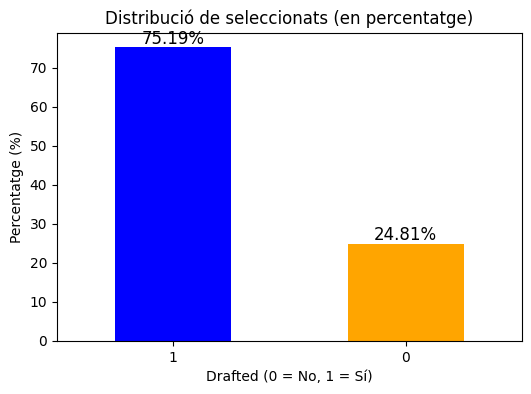

In [36]:
#Tenint ja el dataset que utilitzarem anem a explorar les dades. Primer mirem quin percentatge de jugadors que es presenten al combine son seleccionats


survived_counts = final_dataset['drafted'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
ax = survived_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribució de seleccionats (en percentatge)')
plt.xlabel('Drafted (0 = No, 1 = Sí)')
plt.ylabel('Percentatge (%)')
plt.xticks(rotation=0)

for i, v in enumerate(survived_counts):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=12)

plt.show()



Veiem que el dataset que tenim està molt desbalancejat i això segurament ens portarà problemes. Aquest desbalanceig a la classe 1 es degut a que el nba combine va per invitació i per tant la majoria de invitats son jugadors amb bones probabilitats per ser draftejats

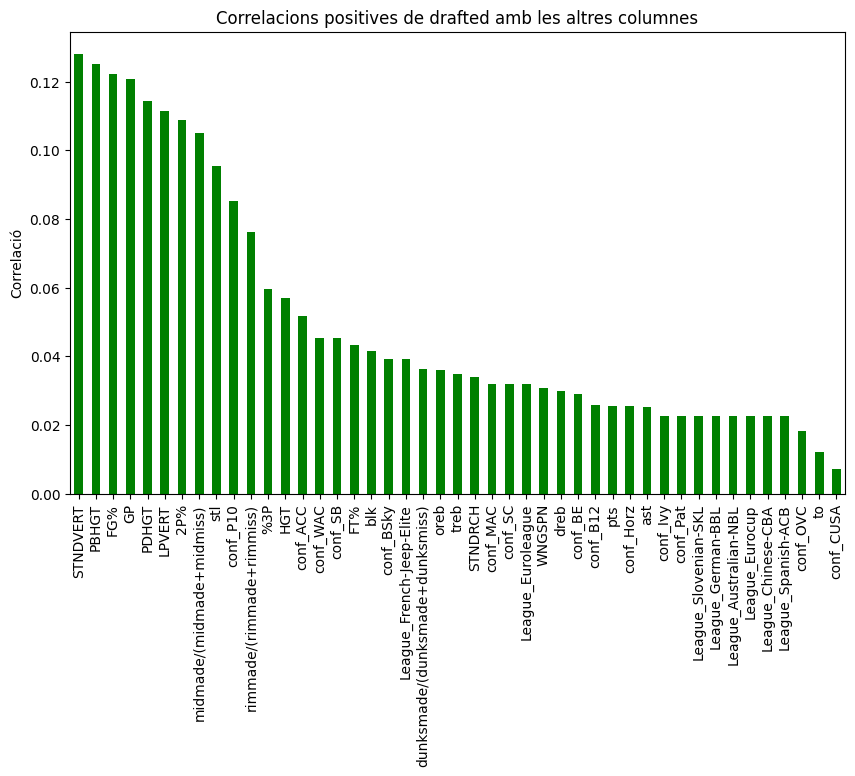

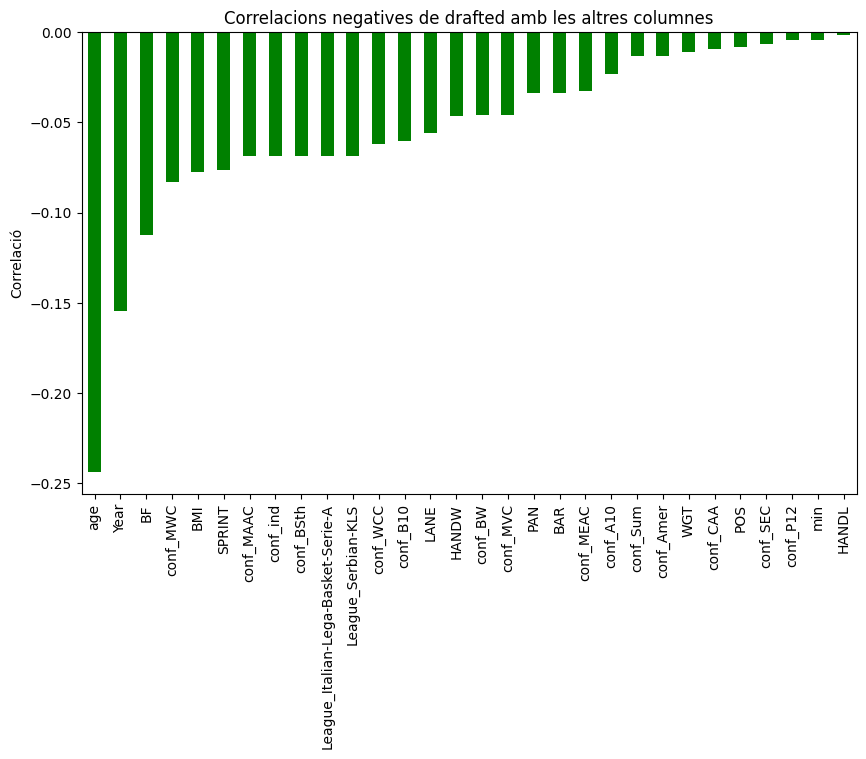

In [37]:

final_dataset2=final_dataset.drop(columns=['pick','Player'])


column_of_interest = 'drafted'

correlacio = final_dataset2.corr()[column_of_interest]
positius = correlacio[correlacio > 0].sort_values(ascending=False).drop(column_of_interest)
negatius = correlacio[correlacio < 0].sort_values(ascending=True)


plt.figure(figsize=(10, 6))
positius.plot(kind='bar', color='green')
plt.title(f'Correlacions positives de {column_of_interest} amb les altres columnes')
plt.ylabel('Correlació')
plt.show()


plt.figure(figsize=(10, 6))
negatius.plot(kind='bar', color='green')
plt.title(f'Correlacions negatives de {column_of_interest} amb les altres columnes')
plt.ylabel('Correlació')
plt.show()




Veiem com de primeres no hi ha molta correlació positiva de la columna drafted amb altres.
Veiem com l'edat del jugador té una forta correlació inversa, ja que els equips molts cops acostumen a preferir draftejar juagdors més joves per el seu potencial. També te correlació inversa el any. Aixó em sorprent però segurament sigui perqué utlimament hi ha una corrent de que els primers seleccionats no es volen presentar al combine per por a fer mals numeros i baixar posicions. Per tan cada any hi ha mes jugadors que son seleccionats sense entrar al combine i aixó baixa la estadística.



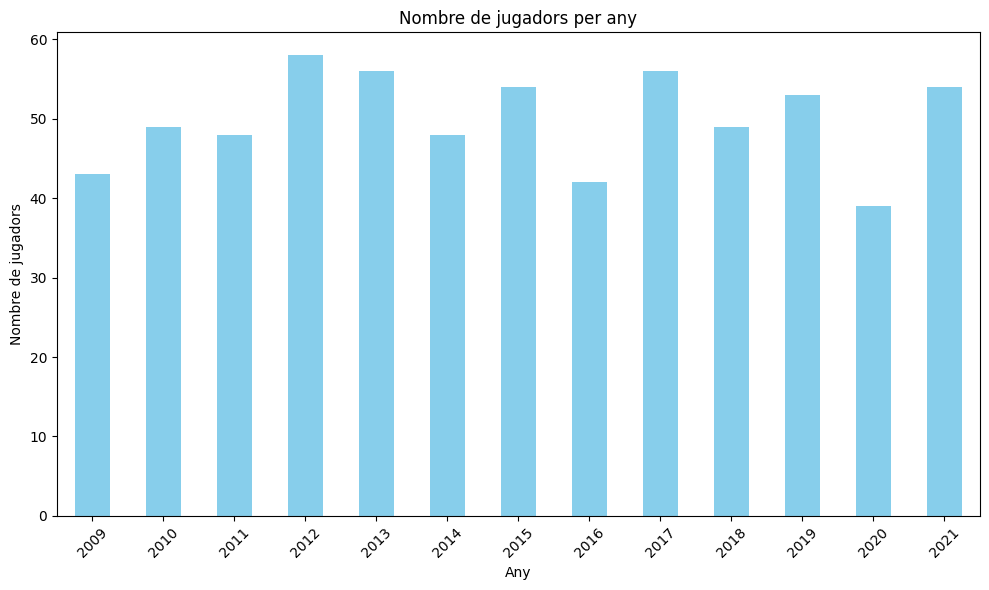

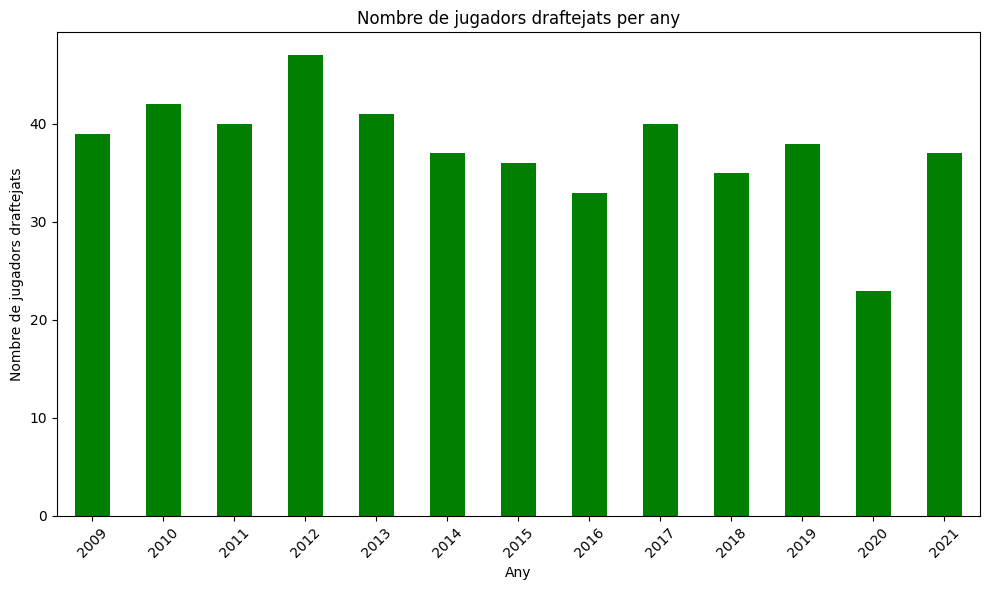

In [38]:
players_per_year = final_dataset['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
players_per_year.plot(kind='bar', color='skyblue')
plt.title('Nombre de jugadors per any')
plt.xlabel('Any')
plt.ylabel('Nombre de jugadors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


drafted_players = final_dataset[final_dataset['drafted'] == 1]
drafted_players_per_year = drafted_players['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
drafted_players_per_year.plot(kind='bar', color='green')
plt.title('Nombre de jugadors draftejats per any')
plt.xlabel('Any')
plt.ylabel('Nombre de jugadors draftejats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podem veure com la majoria de jugadors que es presentaven al combine eren agafats, i que al anar per invitació, mai s'arribava als 60 invitats, per tant es normal que la majoria siguessin elegits

C:\Users\Xavier\AppData\Local\Temp\ipykernel_35188\111556456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_dataset, x='drafted', y='age', palette="pastel")


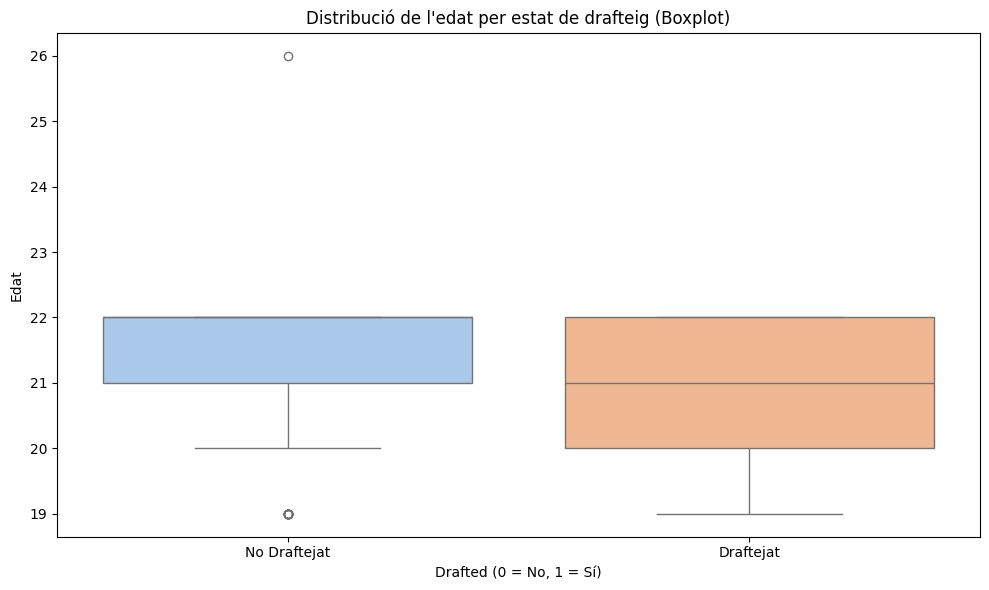

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_dataset, x='drafted', y='age', palette="pastel")

plt.title('Distribució de l\'edat per estat de drafteig (Boxplot)')
plt.xlabel('Drafted (0 = No, 1 = Sí)')
plt.ylabel('Edat')
plt.xticks([0, 1], ['No Draftejat', 'Draftejat'])
plt.tight_layout()
plt.show()

Veiem com la majoria de jugadors que no han set draftejats tenen com a minim 21 anys. Això te sentit ja que els jugadors joves que veuen que tenen oportunitats d'entrar al draft ho proven, sino segueixen algun any més a la universitat.

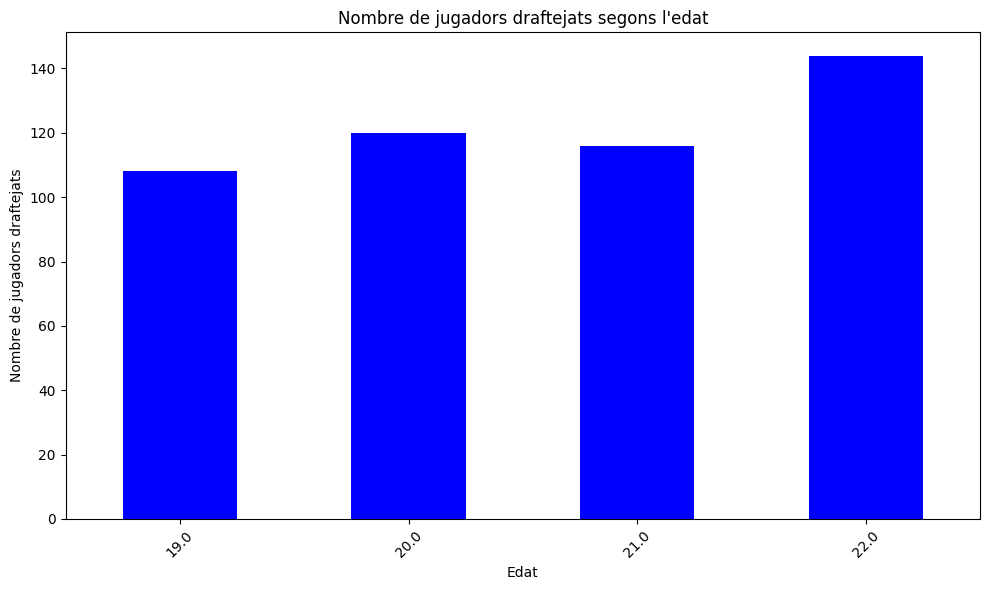

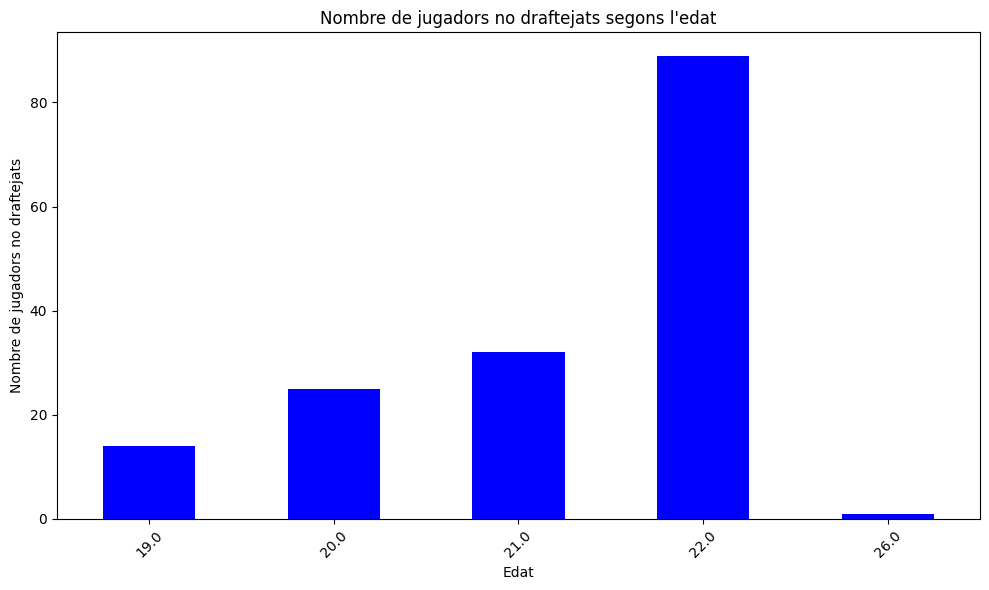

In [40]:

drafted_players = final_dataset[final_dataset['drafted'] == 1]
undrafted_players = final_dataset[final_dataset['drafted'] == 0]

drafted = drafted_players['age'].value_counts().sort_index()
undrafted=undrafted_players['age'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
drafted.plot(kind='bar', color='blue')
plt.title('Nombre de jugadors draftejats segons l\'edat')
plt.xlabel('Edat')
plt.ylabel('Nombre de jugadors draftejats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
undrafted.plot(kind='bar', color='blue')
plt.title('Nombre de jugadors no draftejats segons l\'edat')
plt.xlabel('Edat')
plt.ylabel('Nombre de jugadors no draftejats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Aqui podem seguir veient que els jugadors joves (que es presenten mes perque molts d'ells volen acabar l'universitat), son mes propers a ser elegits

### CLASIFICACIÓ

In [41]:
target = 'drafted'
final_dataset2=final_dataset.drop(columns=['Player','pick'])
attributes = [k for k in final_dataset2.keys() if k!=target]

X = final_dataset2[attributes].to_numpy()
y = final_dataset2[target].to_numpy()

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 1)
nans_per_column = final_dataset.isnull().sum()
columns_with_nans = nans_per_column[nans_per_column > 0]
columns_with_nans = columns_with_nans.sort_values(ascending=True)



El primer objectiu es predir si els jugadors seràn elegits al draft o no, així que fem una classificació amb dues classes

In [42]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


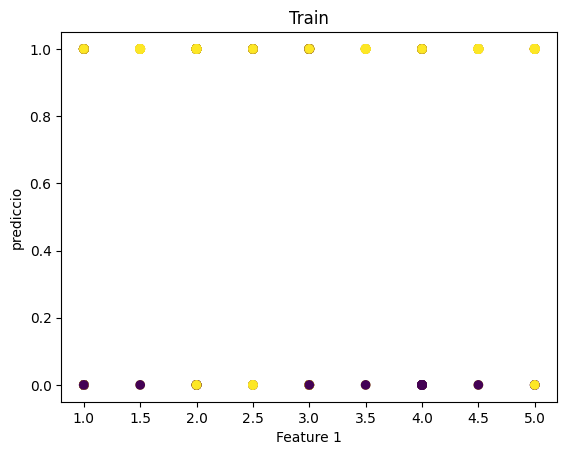

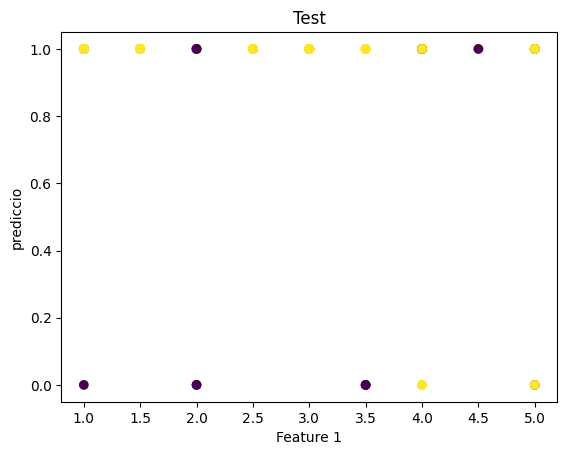

In [43]:
plt.scatter(X_train[:,1],y_train_pred,c= y_train)
plt.xlabel('Feature 1')
plt.ylabel('prediccio')
plt.title('Train')
plt.show()
plt.scatter(X_test[:,1],y_test_pred,c= y_test)
plt.xlabel('Feature 1')
plt.ylabel('prediccio')
plt.title('Test')
plt.show()

In [ ]:

conf_test = confusion_matrix(y_test, y_test_pred)
conf_train = confusion_matrix(y_train, y_train_pred)

prec_test, rec_test, f1_test, sup_test = precision_recall_fscore_support(y_test, y_test_pred)
prec_train, rec_train, f1_train, sup_train = precision_recall_fscore_support(y_train, y_train_pred)

print("=== RESULTATS PER A TEST ===")
print("Confusion Matrix (Test):")
print(conf_test)
print("\nMetrics (Test):")
print(f"Precision: {prec_test}")
print(f"Recall: {rec_test}")
print(f"F1-Score: {f1_test}")
print(f"Support: {sup_test}")

print("\n=== RESULTATS PER A TRAIN ===")
print("Confusion Matrix (Train):")
print(conf_train)
print("\nMetrics (Train):")
print(f"Precision: {prec_train}")
print(f"Recall: {rec_train}")
print(f"F1-Score: {f1_train}")
print(f"Support: {sup_train}")




=== RESULTATS PER A TEST ===
Confusion Matrix (Test):
[[ 7 22]
 [ 5 96]]

Metrics (Test):
Precision: [0.58333333 0.81355932]
Recall: [0.24137931 0.95049505]
F1-Score: [0.34146341 0.87671233]
Support: [ 29 101]

=== RESULTATS PER A TRAIN ===
Confusion Matrix (Train):
[[ 40  92]
 [ 26 361]]

Metrics (Train):
Precision: [0.60606061 0.79690949]
Recall: [0.3030303  0.93281654]
F1-Score: [0.4040404  0.85952381]
Support: [132 387]


Em fixaré en el F1-score, ja que es més indicatiu si el dataset es desbalancejat

In [45]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

smote = SMOTE(random_state=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

svc_model = SVC(kernel='linear', class_weight='balanced', random_state=1)

svc_model.fit(X_train_res, y_train_res)

y_test_pred = svc_model.predict(X_test)

y_train_pred = svc_model.predict(X_train)

print("Classification Report - Test:")
print(classification_report(y_test, y_test_pred))

print("Classification Report - Train:")
print(classification_report(y_train, y_train_pred))

print("Confusion Matrix - Test:")
print(confusion_matrix(y_test, y_test_pred))

print("Confusion Matrix - Train:")
print(confusion_matrix(y_train, y_train_pred))





Classification Report - Test:
              precision    recall  f1-score   support

           0       0.43      0.72      0.54        29
           1       0.90      0.72      0.80       101

    accuracy                           0.72       130
   macro avg       0.66      0.72      0.67       130
weighted avg       0.80      0.72      0.74       130

Classification Report - Train:
              precision    recall  f1-score   support

           0       0.50      0.77      0.61       132
           1       0.90      0.74      0.81       387

    accuracy                           0.75       519
   macro avg       0.70      0.75      0.71       519
weighted avg       0.80      0.75      0.76       519

Confusion Matrix - Test:
[[21  8]
 [28 73]]
Confusion Matrix - Train:
[[102  30]
 [102 285]]


Utilitzo dos tecniques, la primera es aplicar SMOTE. una tècnica per a tractar problemes de desequilibri en les classes del conjunt de dades. Quan un conjunt de dades conté una classe minoritària (amb menys mostres que altres classes), els models poden tenir problemes per aprendre característiques importants d'aquesta classe, ja que tendeixen a estar esbiaixats cap a les classes majoritàries. SMOTE aqui ajuda a equilibrar les classes mitjançant la generació de noves mostres sintètiques per a la classe minoritària.

L'altra és un SVC (support vector classifier) es una aplicació de una SVM (support vector machine) en problemes de classificació. L'utilitzem quan les dades no són linealment separables i s'espera que les relacions no lineals siguin importants, cosa que pot ser ja que abans no ens predia molt be la classe 0. 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

smote = SMOTE(random_state=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

svc_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=1)

svc_model.fit(X_train_res, y_train_res)

y_test_pred = svc_model.predict(X_test)

y_train_pred = svc_model.predict(X_train)

print("Classification Report - Test:")
print(classification_report(y_test, y_test_pred))

print("Classification Report - Train:")
print(classification_report(y_train, y_train_pred))

print("Confusion Matrix - Test:")
print(confusion_matrix(y_test, y_test_pred))

print("Confusion Matrix - Train:")
print(confusion_matrix(y_train, y_train_pred))

y_test_pred_prob = svc_model.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)




Classification Report - Test:
              precision    recall  f1-score   support

           0       0.43      0.72      0.54        29
           1       0.90      0.72      0.80       101

    accuracy                           0.72       130
   macro avg       0.66      0.72      0.67       130
weighted avg       0.80      0.72      0.74       130

Classification Report - Train:
              precision    recall  f1-score   support

           0       0.50      0.77      0.61       132
           1       0.90      0.74      0.81       387

    accuracy                           0.75       519
   macro avg       0.70      0.75      0.71       519
weighted avg       0.80      0.75      0.76       519

Confusion Matrix - Test:
[[21  8]
 [28 73]]
Confusion Matrix - Train:
[[102  30]
 [102 285]]


Ens millora el F1score , pero podem millorarho encara més , aplicarem una tecnica de Feature selection anomenada backward elimination.

És una tècnica de selecció de característiques utilitzada per reduir la dimensionalitat d'un conjunt de dades. Es basa en l'eliminació iterativa de les característiques menys rellevants, amb l'objectiu de millorar el rendiment del model i reduir el soroll en les dades.

In [ ]:
X = final_dataset2[attributes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

remaining_features = list(X_train.columns)
model = SVC(kernel='linear', class_weight='balanced', random_state=1)

model.fit(X_train[remaining_features], y_train)
y_pred = model.predict(X_test[remaining_features])
best_f1_score_backward = f1_score(y_test, y_pred)
best_features = remaining_features.copy()

while len(remaining_features) > 1:
    worst_feature = None
    for feature in remaining_features:
        features_to_test = [f for f in remaining_features if f != feature]
        model.fit(X_train[features_to_test], y_train)
        y_pred = model.predict(X_test[features_to_test])
        f1 = f1_score(y_test, y_pred)

        if f1 > best_f1_score_backward:
            best_f1_score_backward = f1
            worst_feature = feature
            best_features = features_to_test.copy()

    if worst_feature is not None:
        remaining_features.remove(worst_feature)
    else:
        break

print("Característiques seleccionades amb backward selection:", best_features)

model.fit(X_train[best_features], y_train)
y_test_pred = model.predict(X_test[best_features])

print("\nClassification Report - Test:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix - Test:")
print(confusion_matrix(y_test, y_test_pred))

f1 = f1_score(y_test, y_test_pred)
print(f"\nF1-Score final: {f1:.4f}")

non_selected_features = [f for f in X_train.columns if f not in best_features]
print("Característiques no seleccionades:", non_selected_features)


Característiques seleccionades amb backward selection: ['Year', 'POS', 'HGT', 'WGT', 'BMI', 'BF', 'WNGSPN', 'STNDRCH', 'HANDL', 'HANDW', 'STNDVERT', 'LPVERT', 'LANE', 'SPRINT', 'BAR', 'PAN', 'PBHGT', 'PDHGT', 'usg', 'FT%', '2P%', '%3P', 'adjoe', 'rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)', 'dunksmade/(dunksmade+dunksmiss)', 'adrtg', 'stops', 'gbpm', 'min', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts', 'conf_A10', 'conf_ACC', 'conf_Amer', 'conf_B10', 'conf_B12', 'conf_BE', 'conf_BSky', 'conf_BSth', 'conf_BW', 'conf_CAA', 'conf_CUSA', 'conf_Horz', 'conf_Ivy', 'conf_MAAC', 'conf_MAC', 'conf_MEAC', 'conf_MVC', 'conf_OVC', 'conf_P10', 'conf_P12', 'conf_Pat', 'conf_SB', 'conf_SC', 'conf_SEC', 'conf_Sum', 'conf_WAC', 'conf_WCC', 'conf_ind', 'age', 'to', 'FG%', 'League_Australian-NBL', 'League_Chinese-CBA', 'League_Eurocup', 'League_Euroleague', 'League_French-Jeep-Elite', 'League_German-BBL', 'League_Italian-Lega-Basket-Serie-A', 'League_Serbian-KLS', 'League_Slovenian-SKL', 'Leagu

Veiem com millora el f1 score, tot i que la classe 0 no la predeix molt be encara. Elimina 3 característiques , la qual una es una conferencia que deu tenir poca correlació, els partits jugats i els rebots ofensius (Suposo que deu tenir poc pes perque ja tenim els rebots total també )

### Regressió

In [48]:
final_dataset3 = final_dataset[final_dataset['drafted'] != 0]

final_dataset3=final_dataset3.drop(columns=['drafted','Player'])

In [49]:
target_att = 'pick'
attributes = [k for k in final_dataset3.keys() if k!= target_att]
X = final_dataset3[attributes]
y = final_dataset3[[target_att]]

In [50]:
lr = LinearRegression(fit_intercept = False)
lr.fit(X,y)
y_pred = lr.predict(X)
print(y_pred)

r2 = r2_score(y,y_pred)
print (r2)

[[12.40449848]
 [44.25607598]
 [43.43663289]
 [39.73730266]
 [32.96933724]
 [33.53356495]
 [32.77649891]
 [39.05682113]
 [45.48179225]
 [44.38344157]
 [46.95767732]
 [36.73873471]
 [44.59012871]
 [32.70693813]
 [49.81378842]
 [27.87600881]
 [36.76251003]
 [44.31822041]
 [56.79898065]
 [51.62734358]
 [35.45828051]
 [27.98191735]
 [38.93008817]
 [25.28391384]
 [35.2961452 ]
 [34.8007527 ]
 [36.14961112]
 [37.01638967]
 [34.0293366 ]
 [43.06121401]
 [35.07250675]
 [29.89912459]
 [41.36828702]
 [42.3686752 ]
 [31.23259615]
 [49.06035916]
 [24.58051152]
 [35.56128239]
 [37.4994324 ]
 [28.27289108]
 [28.80704308]
 [34.38384507]
 [40.83285029]
 [49.38284153]
 [14.83890405]
 [49.76650542]
 [22.61730175]
 [47.85470975]
 [31.6750161 ]
 [35.68055243]
 [47.17185101]
 [20.47014838]
 [25.81712145]
 [23.86709614]
 [30.96330077]
 [59.27664534]
 [33.94702235]
 [19.58510972]
 [16.48261928]
 [42.51837571]
 [24.28673293]
 [17.62753201]
 [27.66862836]
 [17.99468955]
 [41.51653823]
 [20.38091823]
 [15.89507

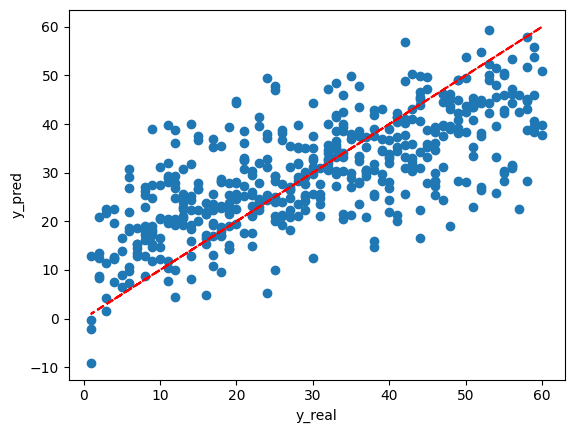

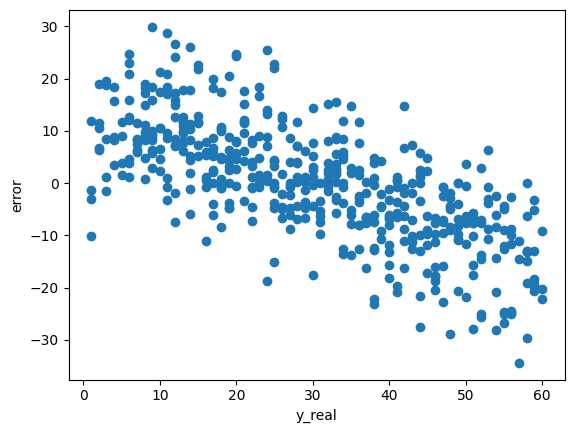

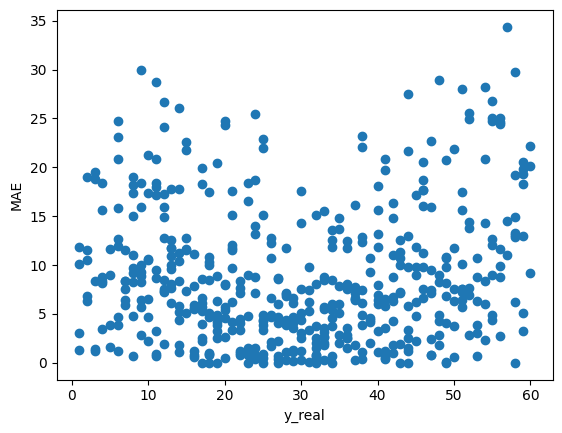

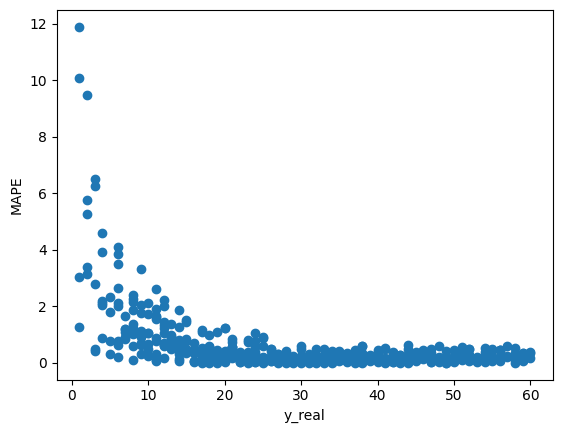

In [51]:
plt.scatter(y,y_pred)
plt.plot(y,y,'--',c = 'red')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

plt.scatter(y,y_pred-y)
plt.xlabel('y_real')
plt.ylabel('error')
plt.show()

plt.scatter(y,abs(y_pred-y))
plt.xlabel('y_real')
plt.ylabel('MAE')
plt.show()

plt.scatter(y,abs(y_pred-y)/y)
plt.xlabel('y_real')
plt.ylabel('MAPE')
plt.show()

R² score: 0.5076339771958865


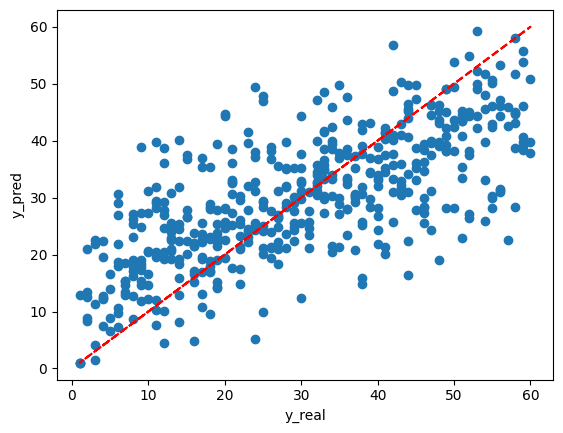

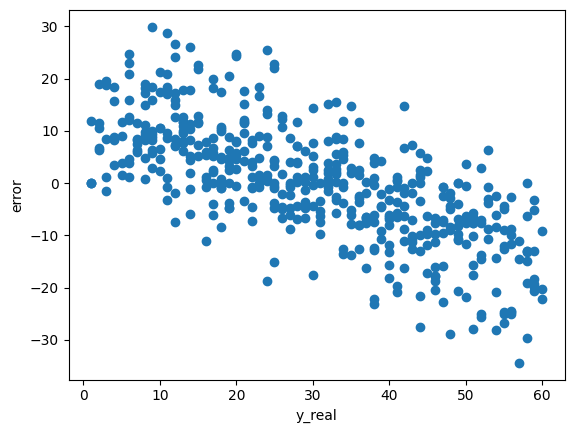

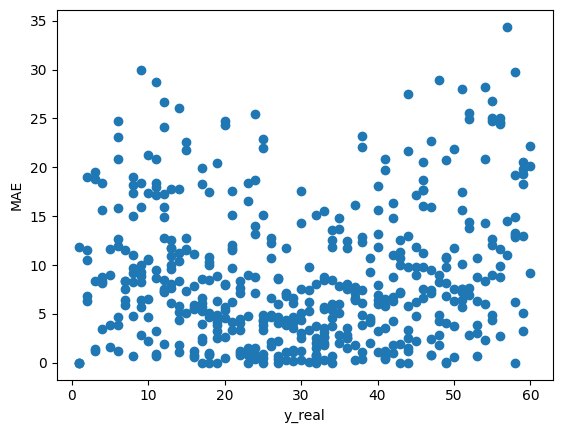

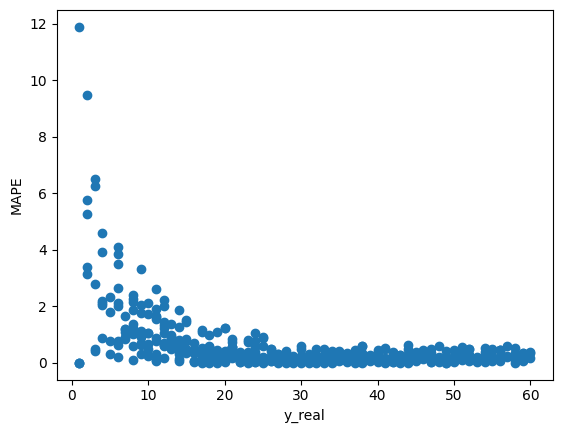

In [52]:
target_att = 'pick'
attributes = [k for k in final_dataset3.keys() if k != target_att]
X = final_dataset3[attributes]
y = final_dataset3[[target_att]]

lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
y_pred = lr.predict(X)
y_pred = np.clip(y_pred, 1, 60) #Sol hi ha 60 eleccions al draft
r2 = r2_score(y, y_pred)
print("R² score:", r2)

plt.scatter(y, y_pred)
plt.plot(y, y, '--', c='red')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

plt.scatter(y, y_pred - y)
plt.xlabel('y_real')
plt.ylabel('error')
plt.show()

plt.scatter(y, np.abs(y_pred - y))
plt.xlabel('y_real')
plt.ylabel('MAE')
plt.show()

plt.scatter(y, np.abs(y_pred - y) / y)
plt.xlabel('y_real')
plt.ylabel('MAPE')
plt.show()


De moment la regressió no prediu molt be, sobretot en els valors dels extrems. Molts cops falla de més de 20 picks

In [53]:
sc_X = StandardScaler()
sc_y = StandardScaler()

X_norm = sc_X.fit_transform(X) 
y_norm = sc_y.fit_transform(y.values.reshape(-1, 1))  

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=1)

lr = LinearRegression(fit_intercept=False)
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)


r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R^2 Train: {r2_train}")
print(f"R^2 Test: {r2_test}")



R^2 Train: 0.5150706505287205
R^2 Test: 0.35989059551961566


El resultat segueix sent baix després de normalitzar, i ademés és possible que hi hagi overfitting per la diferencia entre el test i el train.

In [ ]:

lr = LinearRegression(fit_intercept=False)

lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print("Prediccions per al conjunt d'entrenament:", y_pred_train[:10])  

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R^2 Train: {r2_train}")
print(f"R^2 Test: {r2_test}")

print("\nCoeficients del model:")
for i in range(len(attributes)):
    print(f"{attributes[i]}: {lr.coef_[0][i]}")


Prediccions per al conjunt d'entrenament: [[-0.21405029]
 [-0.49511719]
 [ 0.41674805]
 [ 1.03588867]
 [ 0.09765625]
 [ 0.49511719]
 [ 0.61523438]
 [ 0.2421875 ]
 [-0.05932617]
 [ 0.26269531]]
R^2 Train: 0.5150706505287205
R^2 Test: 0.35989059551961566

Coeficients del model:
Year: 0.2812548879768367
POS: 0.3969099788167791
HGT: 0.6019413062302178
WGT: -0.5571706257475268
BMI: 0.20980216855966038
BF: 0.11708742023019547
WNGSPN: -0.8170211836613781
STNDRCH: -540873821091.5086
HANDL: 0.1397556877633265
HANDW: 0.3615305660964901
STNDVERT: 892172642700.8075
LPVERT: -1431921087871.8853
LANE: 0.08968887746728627
SPRINT: 0.12052366792248603
BAR: 0.483659186648322
PAN: -0.500840070473745
PBHGT: 1762423231089.5923
PDHGT: -1412132990029.86
GP: -0.10311292454293586
usg: -85280534622.11374
FT%: -0.1015002791847186
2P%: -0.20041059015359391
%3P: -0.010725886125057399
adjoe: 225115191799.1049
rimmade/(rimmade+rimmiss): 0.004427374607234857
midmade/(midmade+midmiss): 0.04382449099194674
dunksmade/(du

R² per Lasso (train): 0.5056369977619783
R² per Lasso (test): 0.3623933354610256
R² per Ridge (train): 0.5157396779135164
R² per Ridge (test): 0.3624428487769885
R² per ElasticNet (train): 0.5001928296588845
R² per ElasticNet (test): 0.35416901792617084


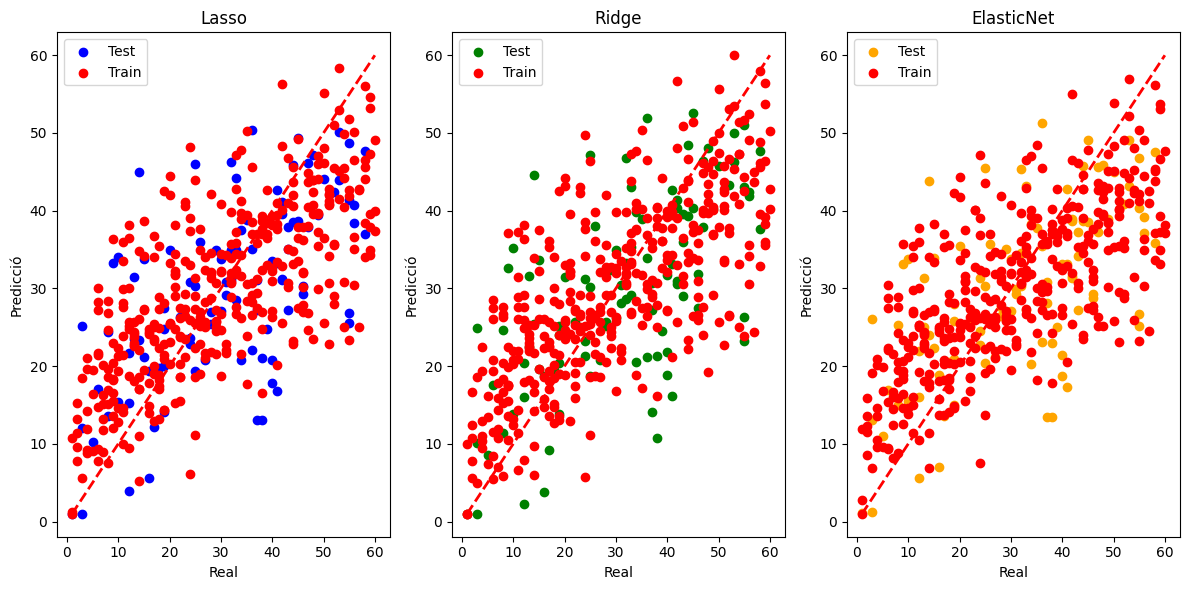

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_model = Lasso(alpha=0.1)
ridge_model = Ridge(alpha=0.1)
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5)

lasso_model.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_scaled, y_train)
elasticnet_model.fit(X_train_scaled, y_train)

y_pred_lasso_test = lasso_model.predict(X_test_scaled)
y_pred_ridge_test = ridge_model.predict(X_test_scaled)
y_pred_elasticnet_test = elasticnet_model.predict(X_test_scaled)

y_pred_lasso_train = lasso_model.predict(X_train_scaled)
y_pred_ridge_train = ridge_model.predict(X_train_scaled)
y_pred_elasticnet_train = elasticnet_model.predict(X_train_scaled)

y_pred_lasso_test = np.clip(y_pred_lasso_test, 1, 60)
y_pred_ridge_test = np.clip(y_pred_ridge_test, 1, 60)
y_pred_elasticnet_test = np.clip(y_pred_elasticnet_test, 1, 60)

y_pred_lasso_train = np.clip(y_pred_lasso_train, 1, 60)
y_pred_ridge_train = np.clip(y_pred_ridge_train, 1, 60)
y_pred_elasticnet_train = np.clip(y_pred_elasticnet_train, 1, 60)

r2_lasso_train = r2_score(y_train, y_pred_lasso_train)
r2_lasso_test = r2_score(y_test, y_pred_lasso_test)

r2_ridge_train = r2_score(y_train, y_pred_ridge_train)
r2_ridge_test = r2_score(y_test, y_pred_ridge_test)

r2_elasticnet_train = r2_score(y_train, y_pred_elasticnet_train)
r2_elasticnet_test = r2_score(y_test, y_pred_elasticnet_test)

print(f"R² per Lasso (train): {r2_lasso_train}")
print(f"R² per Lasso (test): {r2_lasso_test}")
print(f"R² per Ridge (train): {r2_ridge_train}")
print(f"R² per Ridge (test): {r2_ridge_test}")
print(f"R² per ElasticNet (train): {r2_elasticnet_train}")
print(f"R² per ElasticNet (test): {r2_elasticnet_test}")

plt.figure(figsize=(12, 6))


plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lasso_test, color='blue', label='Test')
plt.scatter(y_train, y_pred_lasso_train, color='red', label='Train')
plt.plot([1, 60], [1, 60], 'r--', lw=2)
plt.title('Lasso')
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_ridge_test, color='green', label='Test')
plt.scatter(y_train, y_pred_ridge_train, color='red', label='Train')
plt.plot([1, 60], [1, 60], 'r--', lw=2)
plt.title('Ridge')
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.legend()


plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_elasticnet_test, color='orange', label='Test')
plt.scatter(y_train, y_pred_elasticnet_train, color='red', label='Train')
plt.plot([1, 60], [1, 60], 'r--', lw=2)
plt.title('ElasticNet')
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.legend()

plt.tight_layout()
plt.show()


El valor segueix sense canviar molt, en cap de les tres mesures de Regularització

c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.128e+02, tolerance: 1.029e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.128e+02,


Característiques seleccionades per RFE: Index(['Year', 'POS', 'HGT', 'WGT', 'BMI', 'WNGSPN', 'STNDRCH', 'HANDW',
       'LANE', 'SPRINT', 'PAN', 'PBHGT', 'PDHGT', 'GP', '2P%',
       'dunksmade/(dunksmade+dunksmiss)', 'adrtg', 'min', 'oreb', 'treb',
       'ast', 'stl', 'blk', 'pts', 'conf_ACC', 'conf_B12', 'conf_BE',
       'conf_CUSA', 'conf_MWC', 'conf_P12', 'age', 'to', 'FG%',
       'League_Australian-NBL', 'League_Chinese-CBA', 'League_Eurocup',
       'League_Euroleague', 'League_French-Jeep-Elite', 'League_German-BBL',
       'League_Italian-Lega-Basket-Serie-A', 'League_Serbian-KLS',
       'League_Slovenian-SKL', 'League_Spanish-ACB'],
      dtype='object')

R² al conjunt de train: 0.4406
R² al conjunt de test: 0.4171


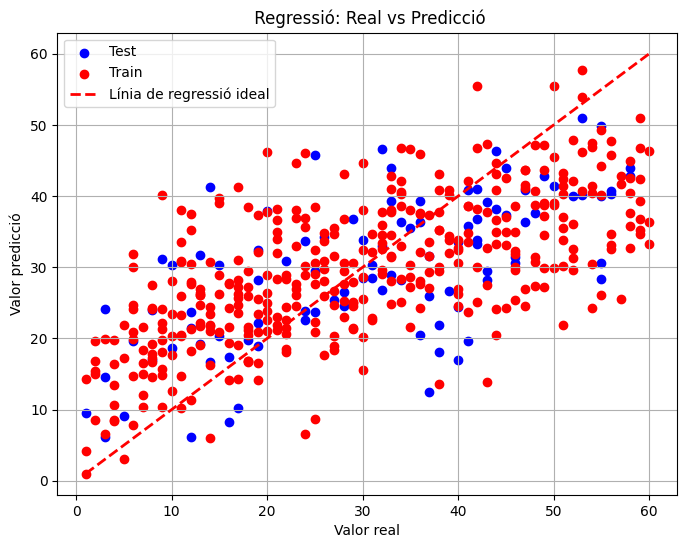

In [56]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

selector = RFE(estimator=Lasso(alpha=0.1), n_features_to_select=43)
selector = selector.fit(X_train, y_train)

selected_features = X.columns[selector.support_]
print(f'\nCaracterístiques seleccionades per RFE: {selected_features}')

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_selected, y_train)

y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

y_train_pred = np.clip(y_train_pred, 1, 60)
y_test_pred = np.clip(y_test_pred, 1, 60)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'\nR² al conjunt de train: {train_r2:.4f}')
print(f'R² al conjunt de test: {test_r2:.4f}')


plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_test_pred, color='blue', label='Test')
plt.scatter(y_train, y_train_pred, color='red', label='Train')
plt.plot([1, 60], [1, 60], 'r--', lw=2, label='Línia de regressió ideal')
plt.title(' Regressió: Real vs Predicció')
plt.xlabel('Valor real')
plt.ylabel('Valor predicció')
plt.legend()
plt.grid(True)
plt.show()


Aplicant un randomForrest resgressor i un RFE el valor al test ha millorat, però segueix sent molt baix. Anem a mirar en quants picks falla


El 95% de les diferències absolutes no superen: 22.32 picks


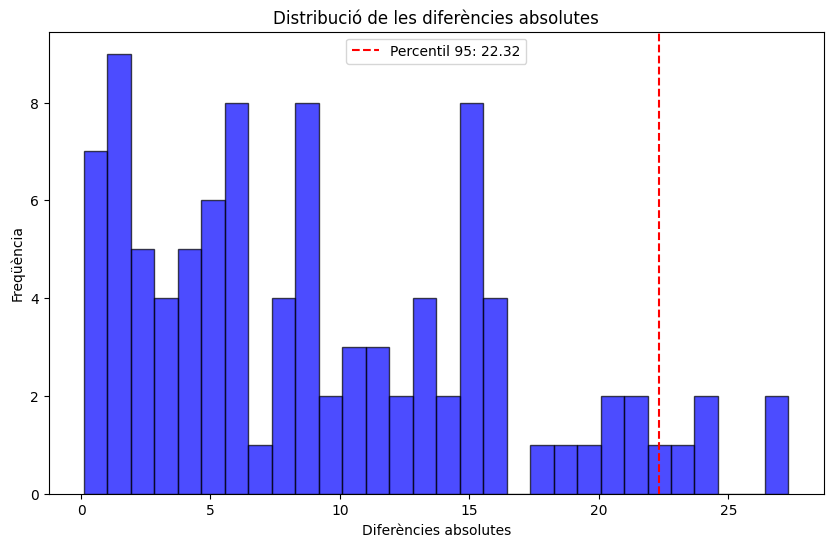

In [57]:
absolute_differences = np.abs(np.array(y_test.values).flatten() - np.array(y_test_pred).flatten())  

percentile_95 = np.percentile(absolute_differences, 95)  
print(f"\nEl 95% de les diferències absolutes no superen: {percentile_95:.2f} picks")

plt.figure(figsize=(10, 6))
plt.hist(absolute_differences, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(percentile_95, color='red', linestyle='--', label=f'Percentil 95: {percentile_95:.2f}')
plt.xlabel('Diferències absolutes')
plt.ylabel('Freqüència')
plt.title('Distribució de les diferències absolutes')
plt.legend()
plt.show()


In [58]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso_model = Lasso(alpha=0.1, random_state=1)  

for cv in range(2, 21):
    lasso_cv_scores = cross_val_score(lasso_model, X_scaled, y, cv=cv, scoring='r2')
    print(f"Lasso Cross-validation R² (cv={cv}): {lasso_cv_scores.mean():.4f} ± {lasso_cv_scores.std():.4f}")
    

    


Lasso Cross-validation R² (cv=2): 0.2234 ± 0.0986
Lasso Cross-validation R² (cv=3): 0.2881 ± 0.0506
Lasso Cross-validation R² (cv=4): 0.3027 ± 0.1036
Lasso Cross-validation R² (cv=5): 0.2833 ± 0.1148
Lasso Cross-validation R² (cv=6): 0.3005 ± 0.1585
Lasso Cross-validation R² (cv=7): 0.3193 ± 0.1534
Lasso Cross-validation R² (cv=8): 0.3154 ± 0.1415
Lasso Cross-validation R² (cv=9): 0.2816 ± 0.1842
Lasso Cross-validation R² (cv=10): 0.3009 ± 0.1923
Lasso Cross-validation R² (cv=11): 0.2871 ± 0.1886
Lasso Cross-validation R² (cv=12): 0.3020 ± 0.2123
Lasso Cross-validation R² (cv=13): 0.2936 ± 0.2043
Lasso Cross-validation R² (cv=14): 0.3020 ± 0.2252
Lasso Cross-validation R² (cv=15): 0.3120 ± 0.2150
Lasso Cross-validation R² (cv=16): 0.2999 ± 0.2208
Lasso Cross-validation R² (cv=17): 0.3026 ± 0.2401
Lasso Cross-validation R² (cv=18): 0.2990 ± 0.2136
Lasso Cross-validation R² (cv=19): 0.2905 ± 0.2239
Lasso Cross-validation R² (cv=20): 0.3114 ± 0.2422


Veiem que fent cross validation podem arribar a tenir una mitja de r^2 de 0.3193 (amb 7  ), pero segueix sent més baix que abans per tant no ho utilitzare

### Classificació multiclasse

Com que la regressió no dona bons resultats hi provarem amb una classificació multiclasse on cada pick sigui una classe

In [59]:
target_att = 'pick'
attributes = [k for k in final_dataset3.keys() if k != target_att]
X = final_dataset3[attributes]
y = final_dataset3[[target_att]]


c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge 

Accuracy (Train) - One-vs-One: 0.9769
Accuracy (Test) - One-vs-One: 0.0306
Error mitjà (Train) - One-vs-One: 0.3538
Error mitjà (Test) - One-vs-One: 15.1735
Percentil 95 dels errors absoluts (Test): 38.00 picks


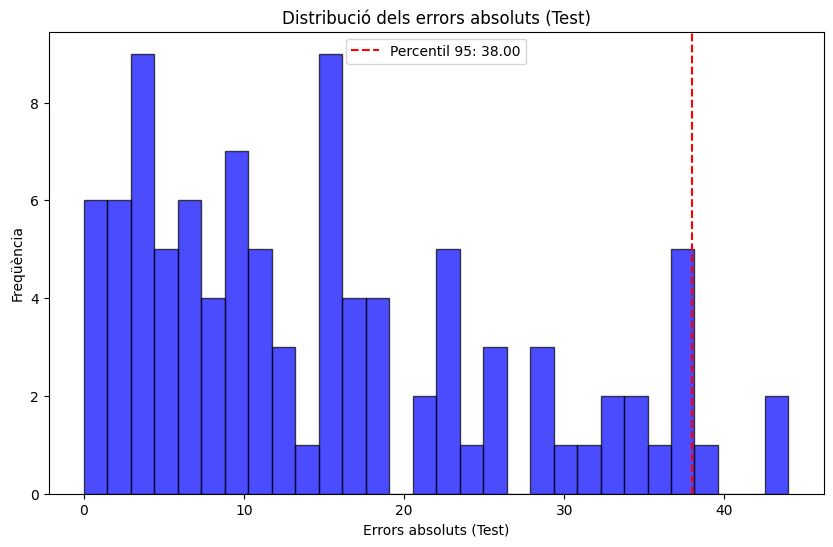

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

y_train_classes = np.clip(y_train, 1, 60).astype(int)
y_test_classes = np.clip(y_test, 1, 60).astype(int)
ovo_model = OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state=1))
ovo_model.fit(X_train, y_train_classes)
y_train_pred_ovo = ovo_model.predict(X_train)
y_test_pred_ovo = ovo_model.predict(X_test)

train_accuracy_ovo = accuracy_score(y_train_classes, y_train_pred_ovo)
test_accuracy_ovo = accuracy_score(y_test_classes, y_test_pred_ovo)

print(f"Accuracy (Train) - One-vs-One: {train_accuracy_ovo:.4f}")
print(f"Accuracy (Test) - One-vs-One: {test_accuracy_ovo:.4f}")

y_train_classes = np.array(y_train_classes).flatten()
y_test_classes = np.array(y_test_classes).flatten()
y_train_pred_ovo = np.array(y_train_pred_ovo).flatten()
y_test_pred_ovo = np.array(y_test_pred_ovo).flatten()

train_errors_ovo = np.abs(y_train_classes - y_train_pred_ovo)
test_errors_ovo = np.abs(y_test_classes - y_test_pred_ovo)
train_average_error_ovo = np.mean(train_errors_ovo)
test_average_error_ovo = np.mean(test_errors_ovo)

print(f"Error mitjà (Train) - One-vs-One: {train_average_error_ovo:.4f}")
print(f"Error mitjà (Test) - One-vs-One: {test_average_error_ovo:.4f}")


percentile_95_test_error = np.percentile(test_errors_ovo, 95)
print(f"Percentil 95 dels errors absoluts (Test): {percentile_95_test_error:.2f} picks")

plt.figure(figsize=(10, 6))
plt.hist(test_errors_ovo, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(percentile_95_test_error, color='red', linestyle='--', label=f'Percentil 95: {percentile_95_test_error:.2f}')
plt.xlabel('Errors absoluts (Test)')
plt.ylabel('Freqüència')
plt.title('Distribució dels errors absoluts (Test)')
plt.legend()
plt.show()


c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Accuracy (Train) - One-vs-All: 0.5231
Accuracy (Test) - One-vs-All: 0.0408
Error mitjà (Train) - One-vs-All: 7.3897
Error mitjà (Test) - One-vs-All: 14.5000
Percentil 95 dels errors absoluts (Test): 38.00 picks


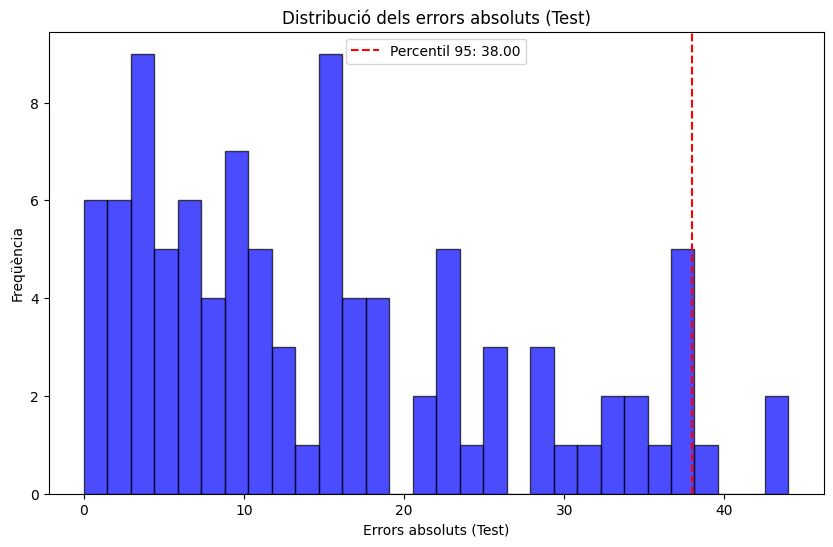

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

y_train_classes = np.clip(y_train, 1, 60).astype(int)
y_test_classes = np.clip(y_test, 1, 60).astype(int)

ova_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=1))
ova_model.fit(X_train, y_train_classes)
y_train_pred_ova = ova_model.predict(X_train)
y_test_pred_ova= ova_model.predict(X_test)

train_accuracy_ova = accuracy_score(y_train_classes, y_train_pred_ova)
test_accuracy_ova = accuracy_score(y_test_classes, y_test_pred_ova)

print(f"Accuracy (Train) - One-vs-All: {train_accuracy_ova:.4f}")
print(f"Accuracy (Test) - One-vs-All: {test_accuracy_ova:.4f}")

y_train_classes = y_train_classes.to_numpy().flatten()
y_test_classes = y_test_classes.to_numpy().flatten()
y_train_pred_ova = y_train_pred_ova.flatten()
y_test_pred_ova= y_test_pred_ova.flatten()

train_errors_ova = np.abs(y_train_classes - y_train_pred_ova)
test_errors_ova= np.abs(y_test_classes - y_test_pred_ova)

train_average_error_ova = np.mean(train_errors_ova)
test_average_error_ova= np.mean(test_errors_ova)

print(f"Error mitjà (Train) - One-vs-All: {train_average_error_ova:.4f}")
print(f"Error mitjà (Test) - One-vs-All: {test_average_error_ova:.4f}")

percentile_95_test_error = np.percentile(test_errors_ovo, 95)
print(f"Percentil 95 dels errors absoluts (Test): {percentile_95_test_error:.2f} picks")

plt.figure(figsize=(10, 6))
plt.hist(test_errors_ovo, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(percentile_95_test_error, color='red', linestyle='--', label=f'Percentil 95: {percentile_95_test_error:.2f}')
plt.xlabel('Errors absoluts (Test)')
plt.ylabel('Freqüència')
plt.title('Distribució dels errors absoluts (Test)')
plt.legend()
plt.show()

Veiem com en els dos casos la presició és molt baixa, això es normal ja que hi han 60 classes. El que ens interessa és la diferencia entre la y real i la predida, i veiem com tenim errors molt grans igualment, més que en la regressió.

Per millorar-ho s'ha aplicat cerca per hiperparàmetres també, però segueix sent un valor baix i un error més alt que en la regressió

Provem finalment si la tecnica forward selection i backward elimination amb un model simple, sense randomForest, ens dona algo diferent

Afegeix age, R² Train: 0.1649
Afegeix Year, R² Train: 0.2420
Afegeix 2P%, R² Train: 0.3014
Afegeix stl, R² Train: 0.3365
Afegeix pts, R² Train: 0.3552
Afegeix conf_CUSA, R² Train: 0.3717
Afegeix PBHGT, R² Train: 0.3884
Afegeix GP, R² Train: 0.3999
Afegeix League_Chinese-CBA, R² Train: 0.4083
Afegeix LANE, R² Train: 0.4165
Afegeix HGT, R² Train: 0.4253
Afegeix POS, R² Train: 0.4366
Afegeix SPRINT, R² Train: 0.4453
Afegeix WGT, R² Train: 0.4537
Afegeix conf_ACC, R² Train: 0.4580
Afegeix conf_B12, R² Train: 0.4633
Afegeix BF, R² Train: 0.4670
Afegeix conf_Sum, R² Train: 0.4698
Afegeix HANDL, R² Train: 0.4724
Afegeix conf_Ivy, R² Train: 0.4753
Afegeix conf_A10, R² Train: 0.4778
Afegeix conf_MWC, R² Train: 0.4803
Afegeix dunksmade/(dunksmade+dunksmiss), R² Train: 0.4826
Afegeix conf_MEAC, R² Train: 0.4849
Afegeix conf_P12, R² Train: 0.4872
Afegeix conf_BW, R² Train: 0.4893
Afegeix FT%, R² Train: 0.4912
Afegeix FG%, R² Train: 0.4934
Afegeix conf_CAA, R² Train: 0.4950
Afegeix ast, R² Train: 0

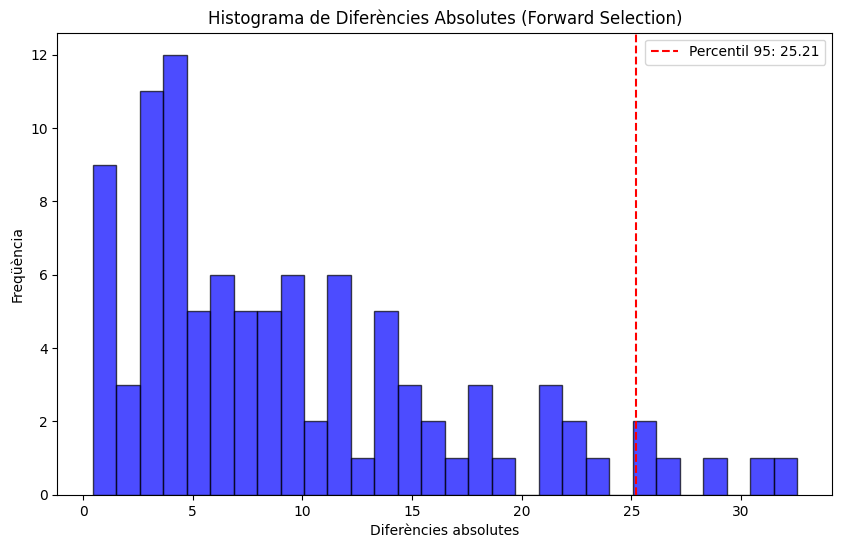


Millors característiques seleccionades (Forward Selection): ['age', 'Year', '2P%', 'stl', 'pts', 'conf_CUSA', 'PBHGT', 'GP', 'League_Chinese-CBA', 'LANE', 'HGT', 'POS', 'SPRINT', 'WGT', 'conf_ACC', 'conf_B12', 'BF', 'conf_Sum', 'HANDL', 'conf_Ivy', 'conf_A10', 'conf_MWC', 'dunksmade/(dunksmade+dunksmiss)', 'conf_MEAC', 'conf_P12', 'conf_BW', 'FT%', 'FG%', 'conf_CAA', 'ast', 'blk', 'min', 'conf_OVC', 'League_Australian-NBL', 'midmade/(midmade+midmiss)', 'conf_BE', 'conf_MVC', 'HANDW', 'PAN', 'League_Spanish-ACB', 'conf_SEC', 'to', 'dreb', 'League_Euroleague', 'PDHGT', 'conf_Pat', 'League_Slovenian-SKL', 'conf_B10', 'conf_WCC', 'oreb', 'BMI', 'League_French-Jeep-Elite', 'treb', 'conf_SC', '%3P', 'conf_MAC', 'conf_BSky', 'conf_Amer', 'conf_WAC', 'conf_P10', 'conf_Horz', 'conf_SB', 'League_Eurocup', 'BAR', 'WNGSPN', 'LPVERT', 'STNDRCH']
Millor R² Train: 0.5159
R² Test (validació): 0.3564
Percentil 95 de les diferències absolutes: 25.21


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

selected_features = []
remaining_features = list(X_train.columns)
best_r2_train = 0
model = LinearRegression()

while remaining_features:
    best_feature = None
    for feature in remaining_features:
        features_to_try = selected_features + [feature]
        model.fit(X_train[features_to_try], y_train)
        y_train_pred = model.predict(X_train[features_to_try])
        current_r2_train = r2_score(y_train, y_train_pred)

        if current_r2_train > best_r2_train:
            best_r2_train = current_r2_train
            best_feature = feature

    if best_feature is not None:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f"Afegeix {best_feature}, R² Train: {best_r2_train:.4f}")
    else:
        break  

model.fit(X_train[selected_features], y_train)
y_test_pred = model.predict(X_test[selected_features])
test_r2 = r2_score(y_test, y_test_pred)

absolute_differences = np.abs(y_test - y_test_pred)

percentile_95 = np.percentile(absolute_differences, 95)

plt.figure(figsize=(10, 6))
plt.hist(absolute_differences, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(percentile_95, color='red', linestyle='--', label=f'Percentil 95: {percentile_95:.2f}')
plt.xlabel('Diferències absolutes')
plt.ylabel('Freqüència')
plt.title('Histograma de Diferències Absolutes (Forward Selection)')
plt.legend()
plt.show()


print(f"\nMillors característiques seleccionades (Forward Selection): {selected_features}")
print(f"Millor R² Train: {best_r2_train:.4f}")
print(f"R² Test (validació): {test_r2:.4f}")
print(f"Percentil 95 de les diferències absolutes: {percentile_95:.2f}")


Elimina League_Australian-NBL, R² Train: 0.5150


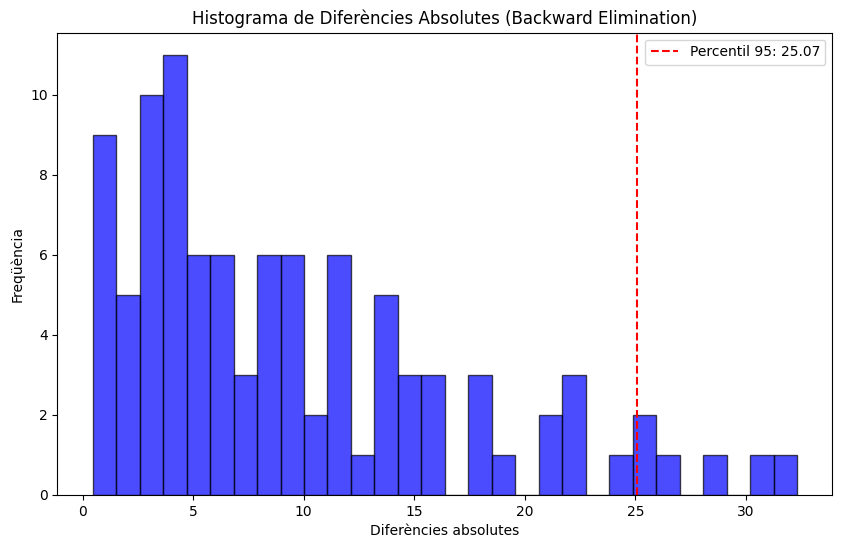


Característiques seleccionades (Backward Elimination): ['Year', 'POS', 'HGT', 'WGT', 'BMI', 'BF', 'WNGSPN', 'STNDRCH', 'HANDL', 'HANDW', 'STNDVERT', 'LPVERT', 'LANE', 'SPRINT', 'BAR', 'PAN', 'PBHGT', 'PDHGT', 'GP', 'usg', 'FT%', '2P%', '%3P', 'adjoe', 'rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)', 'dunksmade/(dunksmade+dunksmiss)', 'adrtg', 'stops', 'gbpm', 'min', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts', 'conf_A10', 'conf_ACC', 'conf_Amer', 'conf_B10', 'conf_B12', 'conf_BE', 'conf_BSky', 'conf_BSth', 'conf_BW', 'conf_CAA', 'conf_CUSA', 'conf_Horz', 'conf_Ivy', 'conf_MAAC', 'conf_MAC', 'conf_MEAC', 'conf_MVC', 'conf_MWC', 'conf_OVC', 'conf_P10', 'conf_P12', 'conf_Pat', 'conf_SB', 'conf_SC', 'conf_SEC', 'conf_Sum', 'conf_WAC', 'conf_WCC', 'conf_ind', 'age', 'to', 'FG%', 'League_Chinese-CBA', 'League_Eurocup', 'League_Euroleague', 'League_French-Jeep-Elite', 'League_German-BBL', 'League_Italian-Lega-Basket-Serie-A', 'League_Serbian-KLS', 'League_Slovenian-SKL', 'Lea

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

selected_features = list(X_train.columns)
model = LinearRegression()

best_r2_train = 0

while len(selected_features) > 0:
    worst_feature = None
    for feature in selected_features:
        features_to_try = [f for f in selected_features if f != feature]
        model.fit(X_train[features_to_try], y_train)
        y_train_pred = model.predict(X_train[features_to_try])
        current_r2_train = r2_score(y_train, y_train_pred)

        if current_r2_train > best_r2_train:
            best_r2_train = current_r2_train
            worst_feature = feature

    if worst_feature is not None:
        selected_features.remove(worst_feature)
        print(f"Elimina {worst_feature}, R² Train: {best_r2_train:.4f}")
    else:
        break  

model.fit(X_train[selected_features], y_train)
y_test_pred = model.predict(X_test[selected_features])
test_r2 = r2_score(y_test, y_test_pred)

absolute_differences = np.abs(y_test - y_test_pred)

percentile_95 = np.percentile(absolute_differences, 95)

plt.figure(figsize=(10, 6))
plt.hist(absolute_differences, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(percentile_95, color='red', linestyle='--', label=f'Percentil 95: {percentile_95:.2f}')
plt.xlabel('Diferències absolutes')
plt.ylabel('Freqüència')
plt.title('Histograma de Diferències Absolutes (Backward Elimination)')
plt.legend()
plt.show()

print(f"\nCaracterístiques seleccionades (Backward Elimination): {selected_features}")
print(f"Millor R² Train: {best_r2_train:.4f}")
print(f"R² Test (validació): {test_r2:.4f}")
print(f"Percentil 95 de les diferències absolutes: {percentile_95:.2f}")


Veiem com el resultat es molt similar al primer cop que s ha fet regressió i per tan es pitjor que quan hem aplicat randomforrest i Lasso anteriorment. Per tant decideixo quedar-me amb aquella métrica

### codi final

In [64]:
final_dataset2=final_dataset.drop(columns=['Player','pick'])
target= 'drafted'
attributes = [k for k in final_dataset2.keys() if k!=target]

X_drafted = final_dataset2[attributes]
y_drafted = final_dataset2[target]

final_dataset3 = final_dataset[final_dataset['drafted'] != 0]
final_dataset3=final_dataset3.drop(columns=['drafted','Player'])

target_att = 'pick'
attributes = [k for k in final_dataset3.keys() if k!= target_att]
X_pick = final_dataset3[attributes]
y_pick = final_dataset3[[target_att]]



In [ ]:



def train_drafted_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

    remaining_features = list(X_train.columns)
    model = SVC(kernel='linear', class_weight='balanced', random_state=1)
    model.fit(X_train[remaining_features], y_train)

    best_f1_score = f1_score(y_test, model.predict(X_test[remaining_features]))
    best_features = remaining_features.copy()

    while len(remaining_features) > 1:
        worst_feature = None
        for feature in remaining_features:
            features_to_test = [f for f in remaining_features if f != feature]
            model.fit(X_train[features_to_test], y_train)
            f1 = f1_score(y_test, model.predict(X_test[features_to_test]))
            if f1 > best_f1_score:
                best_f1_score = f1
                worst_feature = feature
                best_features = features_to_test.copy()

        if worst_feature is not None:
            remaining_features.remove(worst_feature)
        else:
            break

    model.fit(X_train[best_features], y_train)

    return model, best_features


In [66]:
def train_pick_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
    rf_model.fit(X_train, y_train)

    selector = RFE(estimator=Lasso(alpha=0.1), n_features_to_select=43)
    selector = selector.fit(X_train, y_train)

    selected_features = X.columns[selector.support_]

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_selected, y_train)

    train_r2 = r2_score(y_train, lasso.predict(X_train_selected))
    test_r2 = r2_score(y_test, lasso.predict(X_test_selected))

    print(f'\nR² al conjunt de train: {train_r2:.4f}')
    print(f'R² al conjunt de test: {test_r2:.4f}')

    return lasso, selected_features


In [67]:


feature_names = [
    "Year", "Player", "POS", "HGT", "WGT", "BMI", "BF", "WNGSPN", "STNDRCH", "HANDL", "HANDW", "STNDVERT",
    "LPVERT", "LANE", "SPRINT", "BAR", "PAN", "PBHGT", "PDHGT", "GP", "usg", "FT%", "2P%", "%3P", "adjoe",
    "rimmade/(rimmade+rimmiss)", "midmade/(midmade+midmiss)", "dunksmade/(dunksmade+dunksmiss)",
    "adrtg", "stops", "gbpm", "min", "oreb", "dreb", "treb", "ast", "stl", "blk", "pts", "conf_A10", "conf_ACC",
    "conf_Amer", "conf_B10", "conf_B12", "conf_BE", "conf_BSky", "conf_BSth", "conf_BW", "conf_CAA", "conf_CUSA",
    "conf_Horz", "conf_Ivy", "conf_MAAC", "conf_MAC", "conf_MEAC", "conf_MVC", "conf_MWC", "conf_OVC", "conf_P10",
    "conf_P12", "conf_Pat", "conf_SB", "conf_SC", "conf_SEC", "conf_Sum", "conf_WAC", "conf_WCC", "conf_ind", "age",
    "to", "FG%", "League_Australian-NBL", "League_Chinese-CBA", "League_Eurocup", "League_Euroleague",
    "League_French-Jeep-Elite", "League_German-BBL", "League_Italian-Lega-Basket-Serie-A", "League_Serbian-KLS",
    "League_Slovenian-SKL", "League_Spanish-ACB"
]

player_data = [
    2024, "Zach Edey", 5.0, 88.2, 305, 27.1, 0.084, 96, 116.4, 9.75, 11.0, 26, 29.5, 11.37, 3.16, 1.088, 
    107.25, 142.4, 145.9, 33, 32.8, 0.711, 0.624, 0.5, 135.9, 0.624, 0.0, 0.75, 
    116.95, 201.66732530516433, 7.0, 32.0, 4.6, 7.5, 12.2, 2.0, 0.3, 2.2, 
    25.2, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 2.3, 0.624, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
    0.0, 0.0, 0.0
]

model_drafted, best_features_classification = train_drafted_model(X_drafted, y_drafted)
lasso, selected_features_regression = train_pick_model(X_pick, y_pick)

example_player = pd.DataFrame([player_data], columns=feature_names)

X_player_classification = example_player[best_features_classification]
drafted_prediction = model_drafted.predict(X_player_classification)





c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.128e+02, tolerance: 1.029e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.128e+02,


R² al conjunt de train: 0.4406
R² al conjunt de test: 0.4171


c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.238e+02, tolerance: 1.029e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.238e+02, tolerance: 1.029e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

In [68]:
if drafted_prediction[0] == 1:  
    X_player_regression = example_player[selected_features_regression]
    pick_prediction = lasso.predict(X_player_regression)[0]
    pick_prediction = np.clip(pick_prediction, 1, 60)
    print(f"El jugador serà draftejat en el pick {int(pick_prediction)}.")
else:
    print("El jugador no serà draftejat.")


El jugador serà draftejat en el pick 17.


In [69]:
player_data = [
    2024, "Bronny James", 2.0, 73.8, 210.4, 27.17, 0.083, 80.7, 99, 8.50, 9.50, 32, 40.5, 10.96, 3.09, 1.093, 
    80.75, 131, 139.5, 25, 16.1, 0.676, 0.481, 0.267, 97.6, 0.75, 0.33, 0.8, 
    116.95, 150.3, 0.3, 19.3, 0.3, 2.6, 2.9, 2.1, 0.8, 0.2, 
    4.8, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 1.1, 0.366, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
    0.0, 0.0, 0.0
]


model_drafted, best_features_classification = train_drafted_model(X_drafted, y_drafted)
lasso, selected_features_regression = train_pick_model(X_pick, y_pick)

example_player = pd.DataFrame([player_data], columns=feature_names)

X_player_classification = example_player[best_features_classification]
drafted_prediction = model_drafted.predict(X_player_classification)


c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.128e+02, tolerance: 1.029e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.128e+02,


R² al conjunt de train: 0.4406
R² al conjunt de test: 0.4171


c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.237e+02, tolerance: 1.029e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.237e+02, tolerance: 1.029e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Xavier\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

In [70]:
if drafted_prediction[0] == 1:  
    X_player_regression = example_player[selected_features_regression]
    pick_prediction = lasso.predict(X_player_regression)[0]
    pick_prediction = np.clip(pick_prediction, 1, 60)
    print(f"El jugador serà draftejat en el pick {int(pick_prediction)}.")
else:
    print("El jugador no serà draftejat.")


El jugador serà draftejat en el pick 45.
